### Libraries

In [11]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, TimeDistributed, Input
from tensorflow.keras.models import load_model

### MLFlow settings

Setup MLflow:

In [19]:
import os
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_CNN_Testing-CNN_LSTM_1_seasonality-Loop_1"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


### My own functions

In [13]:
from functions_laura.Data_processing import resample, resample_one_station, one_station_resample_with_seasonality_no_uuid
from functions_laura.Data_cleaning import data_cleaning_datetime

from functions_nico import nico_fuelprophet

# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

# Loading train/test data

In [14]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Rename date to datetime

In [15]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

# Functions script

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Input
import mlflow.keras
import keras
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


###################################################################################################
def prepare_forecast_data(df_test, scaler,
                            forecast_output_start,
                            days_output,
                            fuel='e5',
                            window_size=288):
    """
    Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

    Parameters:
    - df: pandas DataFrame with datetime index
    - scaler: fitted MinMaxScaler
    - forecast_input_start: datetime, start of input window
    - forecast_output_start: datetime, start of output window
    - days_input: number of days for input
    - days_output: number of days for prediction
    - fuel: string, name of the column to use (default: 'e5')
    - window_size: number of steps per day (default: 288 for 5-min data)

    Returns:
    - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
    ###- forecast_timestamps: list of timestamps corresponding to each prediction###
    """
    df = df_test.copy()
    
    
    df["time_index"] = np.arange(len(df))

    input_mask = (df.index < forecast_output_start)
    output_mask = (df.index >= forecast_output_start) & (
        df.index < forecast_output_start + pd.Timedelta(days=days_output)
    )

    input_rows = df[input_mask]["time_index"].values
    output_rows = df[output_mask]["time_index"].values

    # expected_input_rows = days_input * window_size
    # expected_output_rows = days_output * window_size

    # if len(input_rows) != expected_input_rows:
    #     raise ValueError(f"Expected {expected_input_rows} input rows, got {len(input_rows)}")
    # if len(output_rows) != expected_output_rows:
    #     raise ValueError(f"Expected {expected_output_rows} output rows, got {len(output_rows)}")

    start_idx = input_rows[0]
    end_idx = output_rows[-1] + 1

    values = df[['seasonal_component', fuel]].values
    scaled_values = scaler.transform(values)
    forecast_slice = scaled_values[start_idx:end_idx]

    total_target_steps = len(output_rows)
    X_forecast = []

    for i in range(total_target_steps):
        window = forecast_slice[i:i + window_size]
        X_forecast.append(window)

    X_forecast = np.array(X_forecast)  # shape: (288, 288, 1)
    #forecast_timestamps = df.iloc[output_rows].index.tolist()

    y_test = df.loc[
    (df.index >= forecast_output_start) &
    (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
    fuel  # or whatever fuel column you're forecasting
    ].values.reshape(-1, 1)

    return X_forecast, y_test
####################################################################################################
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df_train, df_test,
        start_forecast=None,
        fuel='e5',
        output_days=1,
        verbose=True):
    
    # Filter and resample
    df_train = one_station_resample_with_seasonality_no_uuid(df_train)
    df_test = one_station_resample_with_seasonality_no_uuid(df_test)

    # Split data
    # Find the middle point of df_test
    middle_idx = len(df_train) // 2
    
    test_df = df_test
    train_df = df_train[:middle_idx].copy()  # First half
    val_df = df_train[middle_idx:].copy()  # Second half

    # set datetime index
    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)

    # Calculate start_forecast automatically (output_days days before end of test set)
    start_forecast = test_df.index.max() - pd.Timedelta(days=output_days)

    # Scaling
    scaler = MinMaxScaler()
    features = ['seasonal_component', fuel]
    scaler.fit(train_df[features])

    scaled_train = scaler.transform(train_df[features])
    scaled_val = scaler.transform(val_df[features])
    #scaled_test = scaler.transform(test_df[[fuel]])  # optional

    # Sequence generation
    window_size = 288
    target_col_index = 1

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Forecast setup
    start_forecast = pd.to_datetime(start_forecast)
    X_forecast, y_test = prepare_forecast_data(test_df, forecast_output_start=start_forecast,
                                       days_output=output_days, scaler=scaler)


    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Data_overview.png")
        mlflow.log_artifact("Data_overview.png")
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.savefig("KDE.png")
        mlflow.log_artifact("KDE.png")
        plt.show()

        print(f"Train shape: {X.shape}  | Validation shape: {X_val.shape}")
        print(f"Forecast setup from {test_df.index.min()} to {start_forecast}, to predict {output_days} day(s)")
        print(f"Test set range: {test_df.index.min()} to {test_df.index.max()}")

    return X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df

#########################################################################################

def build_model(model_type, params, input_shape=(288, 2)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

########################################################################

def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_output=None, input_shape=(288, 2)):
    # Log parameters manually (optional if autolog is on)
    mlflow.log_param("days_output", days_output)
    mlflow.set_tag("dataset", f'{df_train}_{df_test}')
    mlflow.set_tag("model_type", model_type)
    
    model = build_model(model_type=model_type, params=params, input_shape=input_shape)
    # Train model
    history = model.fit(
        X, y,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    # Log final metrics manually if you want more control
    final_val_loss = history.history['val_loss'][-1]
    mlflow.log_metric("final_val_loss", final_val_loss)
    # Optionally log a plot
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss over Epochs")
    plt.legend()
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")
    model_path = 'model.keras'
    keras.saving.save_model(model, model_path, save_format="keras")
    mlflow.log_artifact(model_path)

    return model, history

########################################################################

# Helper Functions

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        fuel='e5',
        model= None,
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''
    
    #make predictions
    y_pred_forecast = model.predict(X_forecast)
    #scale the predictions back to original scale
    y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=1, scaler=scaler)

    # reattach the datetime to prediction
    n_predictions = len(y_pred)
    last_timestamp = test_df.index.max()
    start_datetime = last_timestamp - pd.Timedelta(days=output_days)
    time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

    #combine into a DataFrame
    y_pred_df = pd.DataFrame({
        "datetime": time_index,
        "Predicted E5": y_pred
    })
    #make datetime index
    y_pred_df.set_index('datetime', inplace=True)

    # Save forecast to file
    np.savetxt("forecast.csv", y_pred_df, delimiter=",") 
    mlflow.log_artifact("forecast.csv")

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Forecast MSE:", mae)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    mlflow.log_metric("test_mae", mae)
    mlflow.log_metric("test_mape", mape)
    mlflow.log_metric("test_R2", r2)
    #print y_pred to check if it looks as expected
    print(y_pred_df.head()) 

    # Plot
    # Set parameters
    colors = {
        "background": "#f9fcfc",
        "gridcolor": "#dcdbd9",
        "legendedge": "#dcdbd9",
        "legendface": "white",
        "legendcol": "black",
        "textcolor": "black"
    }
    # Create a figure and axis with custom size
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(test_df[fuel], label=f'True Test {fuel}', drawstyle='steps-post', linewidth=3) # line width
    plt.plot(y_pred_df, drawstyle='steps-post', linewidth=3)
    # Set grid with custom color
    ax.grid(True, color=colors["gridcolor"])
    # Change border (spine) colors
    for spine in ax.spines.values():
        spine.set_edgecolor(colors["gridcolor"])
    # Set title and labels
    ax.set_title("Fuel price prediction of one gas station", fontweight="bold", fontsize=18, color=colors["textcolor"])
    ax.set_xlabel("time", fontweight="bold", fontsize=16, color=colors["textcolor"])
    ax.set_ylabel(f"{fuel} price (€/l)", fontweight="bold", fontsize=16, color=colors["textcolor"])
    # Customize tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
        label.set_fontweight('normal')
    # Set background color
    ax.set_facecolor(colors["background"])
    fig.patch.set_facecolor(colors["background"])
    # Create legend
    plt.legend(fontsize=16,loc='upper right', 
               edgecolor=params.get("legendedge"), 
               facecolor=params.get("legendface"), 
               labelcolor = params.get("legendcol"),
               framealpha=1)
    plt.savefig("forecast.png")
    mlflow.log_artifact("forecast.png")
    plt.show()




# Start of the analysis

In [17]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


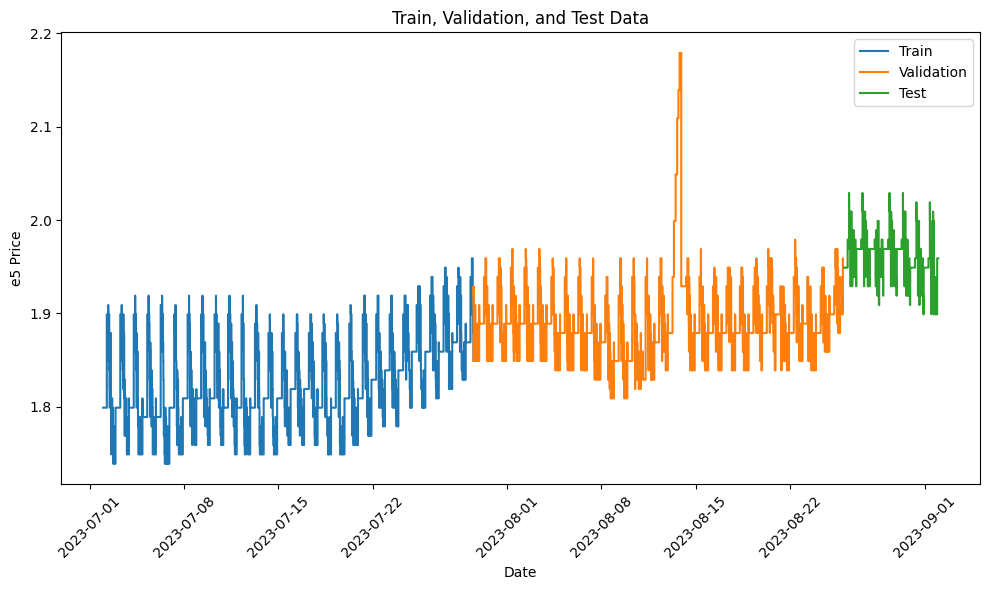

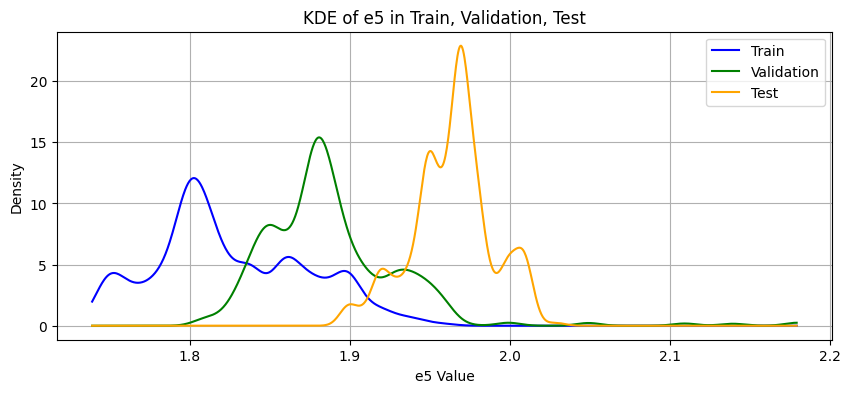

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-08-26 00:05:00 to 2023-09-01 00:00:00, to predict 1 day(s)
Test set range: 2023-08-26 00:05:00 to 2023-09-02 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0235 - val_loss: 0.0039
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Forecast MSE: 0.011262125488784648
                     Predicted E5
datetime                         
2023-09-01 00:00:00      1.961780
2023-09-01 00:05:00      1.961448
2023-09-01 00:10:00      1.961462
2023-09-01 00:15:00      1.960936
2023-09-01 00:20:00      1.960861


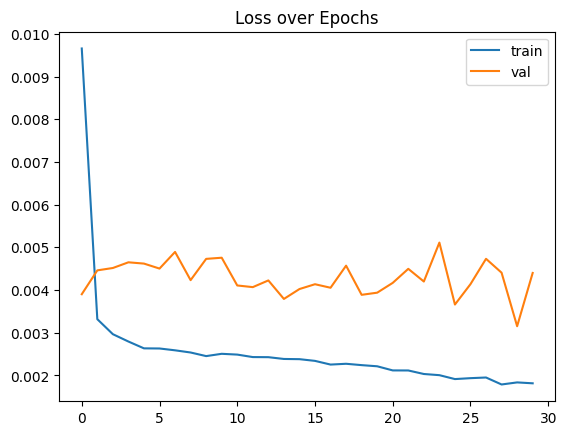

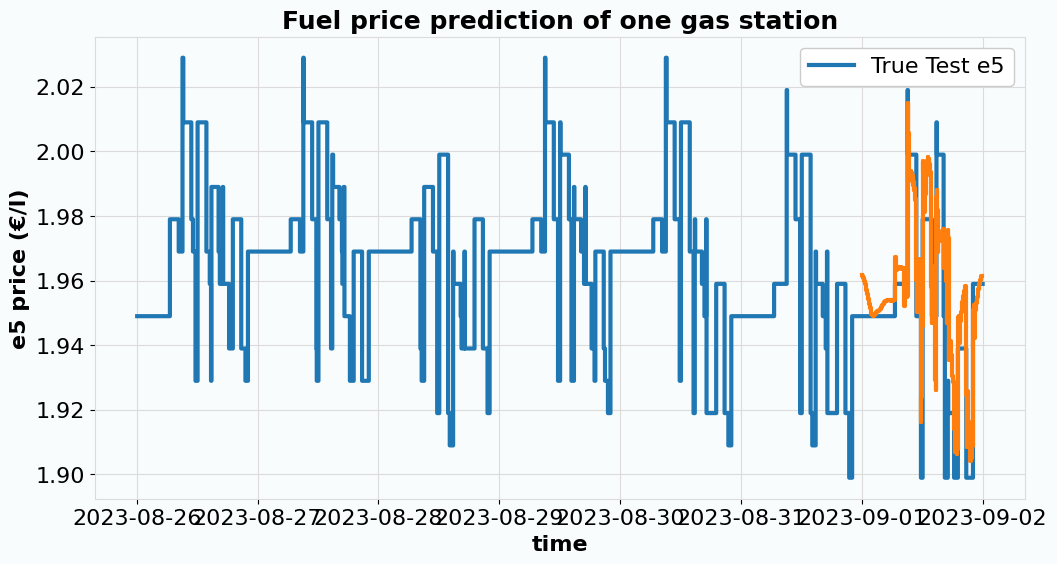

Successfully processed df01

Processing dataset: df02


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


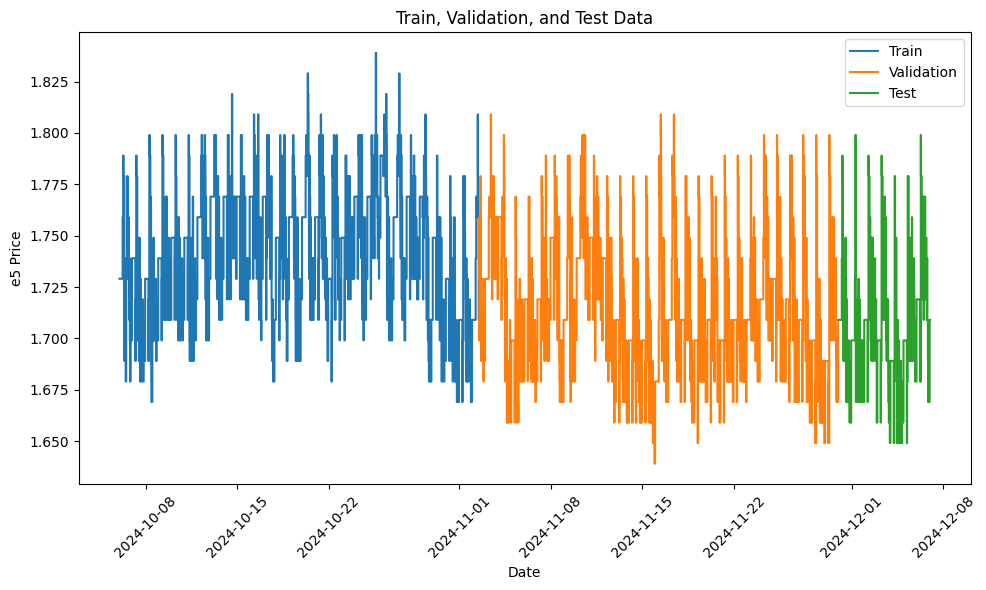

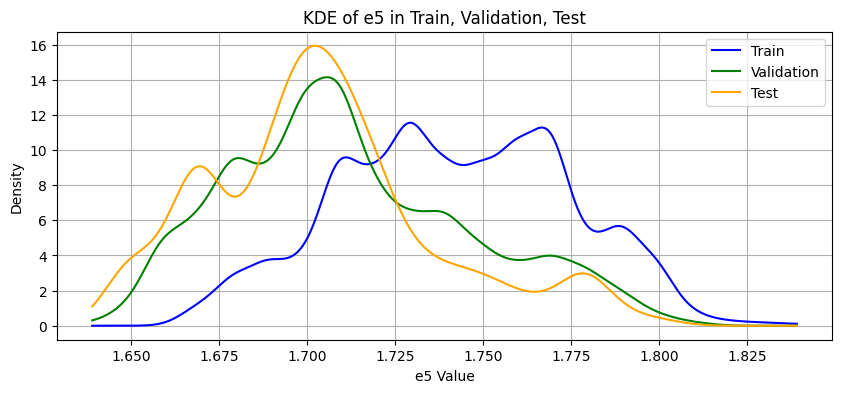

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-11-30 00:05:00 to 2024-12-06 00:00:00, to predict 1 day(s)
Test set range: 2024-11-30 00:05:00 to 2024-12-07 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0343 - val_loss: 0.0072
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.03482024818713801
                     Predicted E5
datetime                         
2024-12-06 00:00:00      1.702272
2024-12-06 00:05:00      1.703974
2024-12-06 00:10:00      1.702813
2024-12-06 00:15:00      1.703510
2024-12-06 00:20:00      1.702557


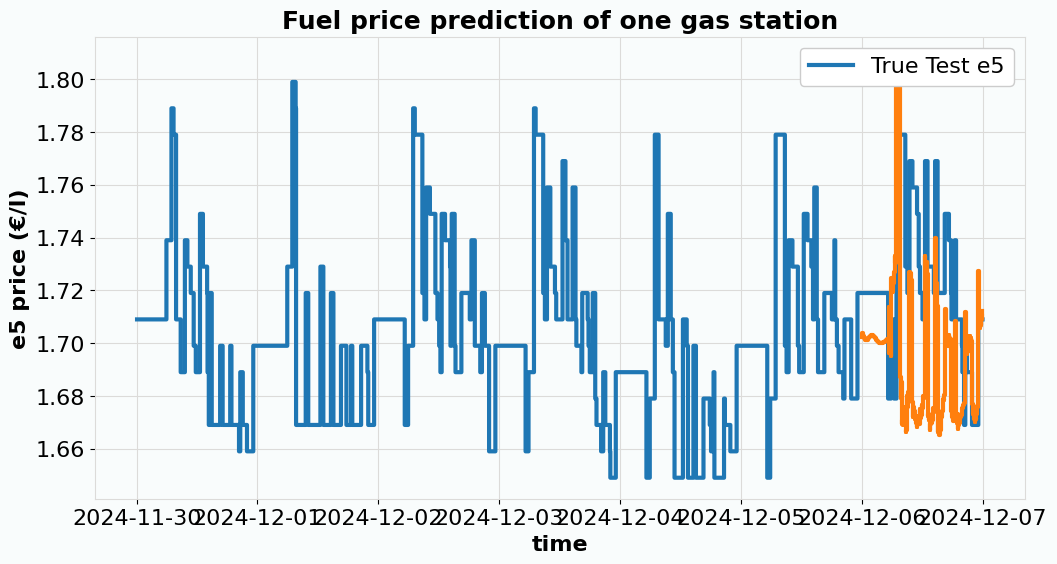

Successfully processed df02

Processing dataset: df03


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


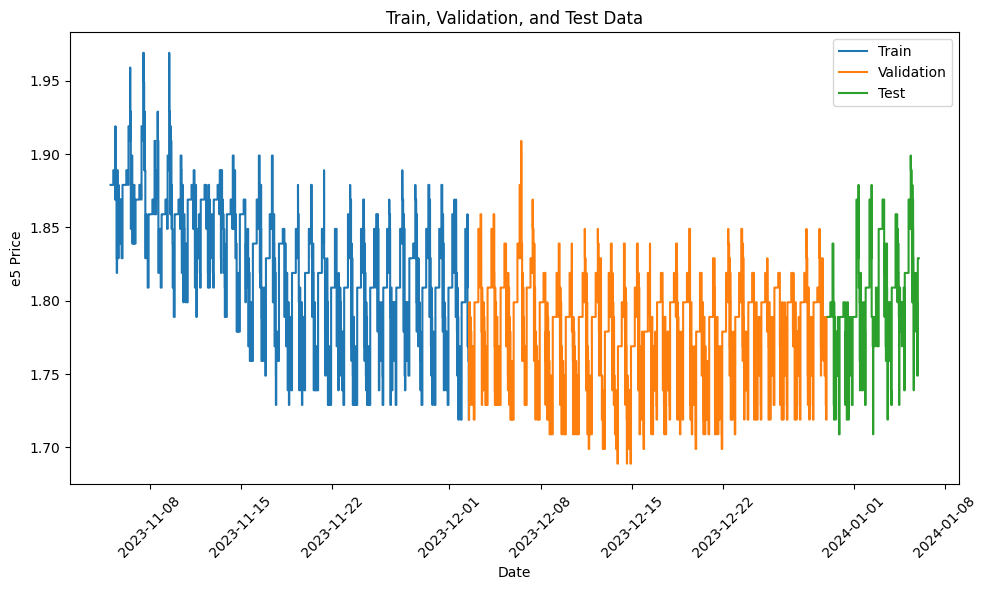

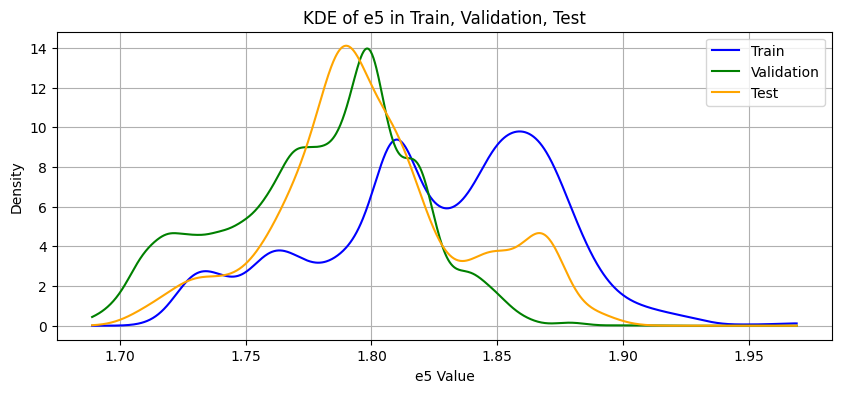

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-30 00:05:00 to 2024-01-05 00:00:00, to predict 1 day(s)
Test set range: 2023-12-30 00:05:00 to 2024-01-06 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0306 - val_loss: 0.0027
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecast MSE: 0.0522177658512049
                     Predicted E5
datetime                         
2024-01-05 00:00:00      1.789184
2024-01-05 00:05:00      1.789037
2024-01-05 00:10:00      1.788953
2024-01-05 00:15:00      1.788830
2024-01-05 00:20:00      1.788792


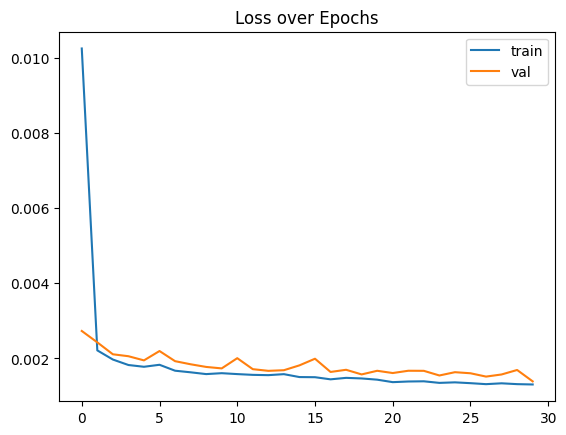

Successfully processed df03

Processing dataset: df04


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


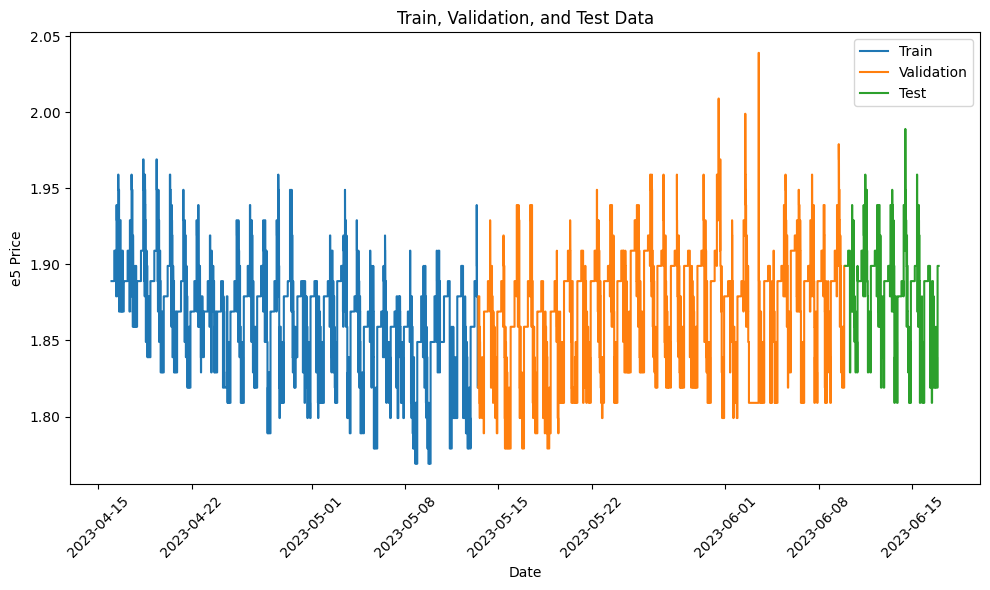

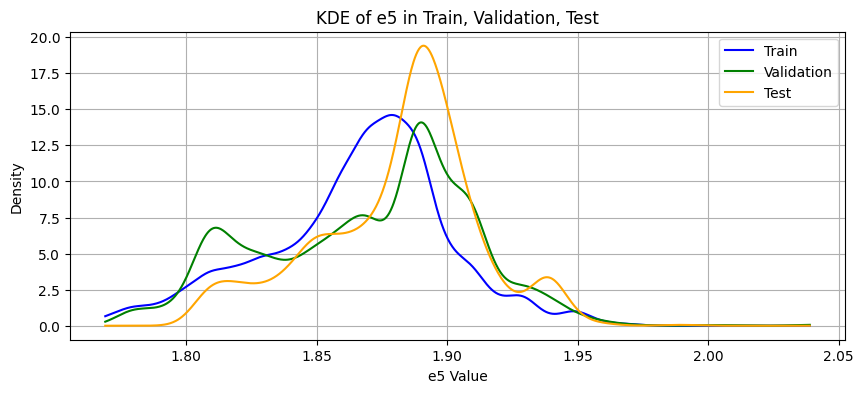

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-06-10 00:05:00 to 2023-06-16 00:00:00, to predict 1 day(s)
Test set range: 2023-06-10 00:05:00 to 2023-06-17 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0187 - val_loss: 0.0048
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.020916647327442986
                     Predicted E5
datetime                         
2023-06-16 00:00:00      1.888409
2023-06-16 00:05:00      1.887816
2023-06-16 00:10:00      1.888456
2023-06-16 00:15:00      1.887878
2023-06-16 00:20:00      1.888349


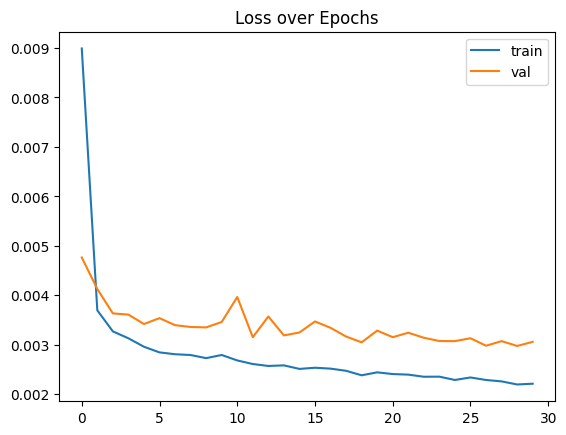

Successfully processed df04

Processing dataset: df05


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


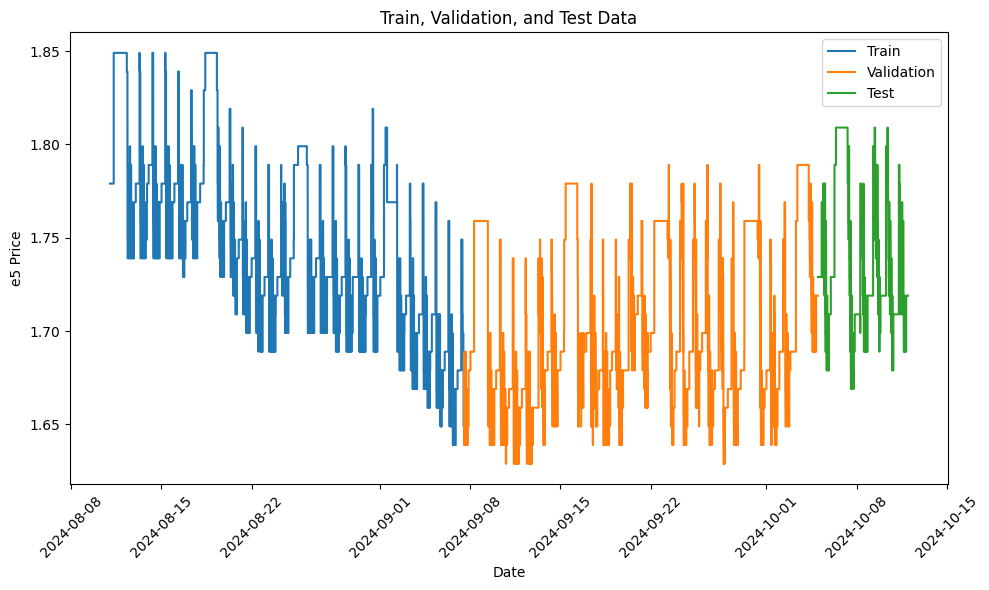

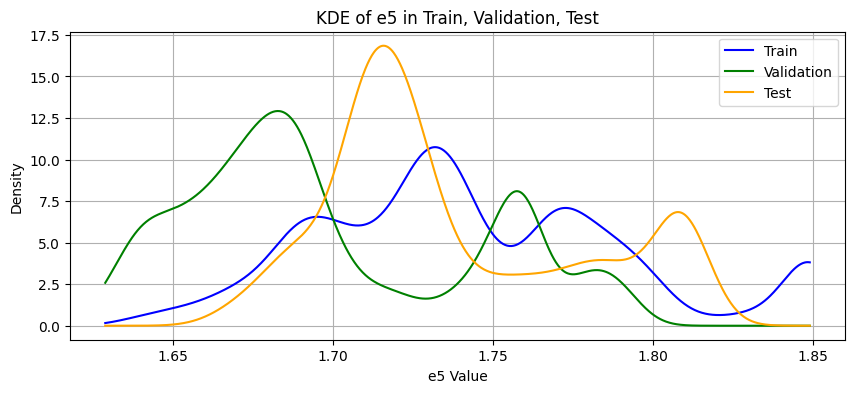

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-10-05 00:05:00 to 2024-10-11 00:00:00, to predict 1 day(s)
Test set range: 2024-10-05 00:05:00 to 2024-10-12 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0338 - val_loss: 0.0039
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.06242011370240826
                     Predicted E5
datetime                         
2024-10-11 00:00:00      1.714082
2024-10-11 00:05:00      1.724546
2024-10-11 00:10:00      1.733701
2024-10-11 00:15:00      1.729175
2024-10-11 00:20:00      1.728977


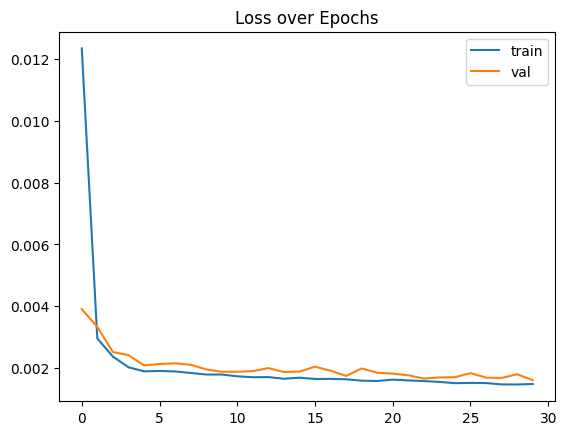

Successfully processed df05

Processing dataset: df06
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

Processing dataset: df07


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


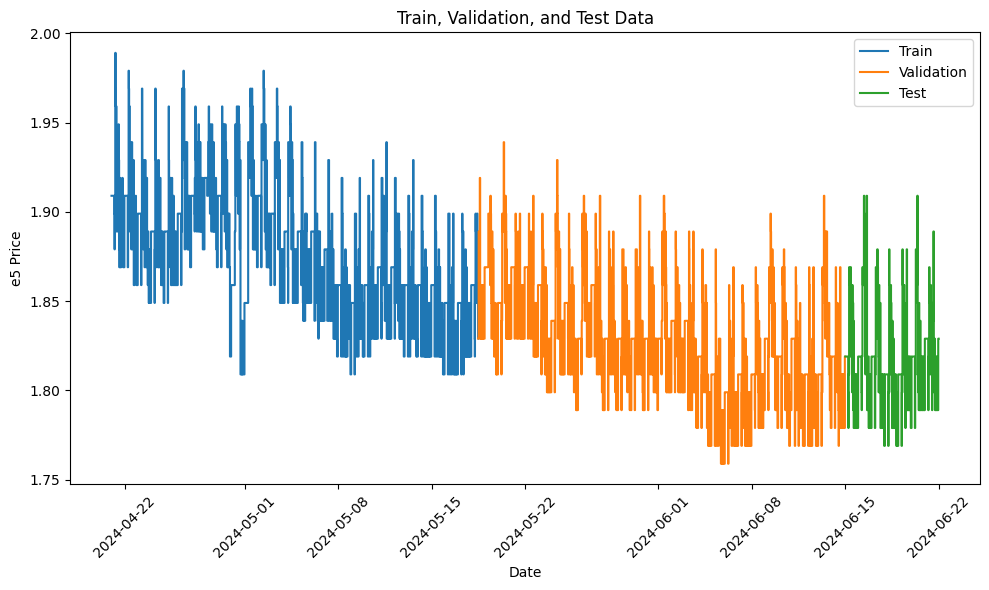

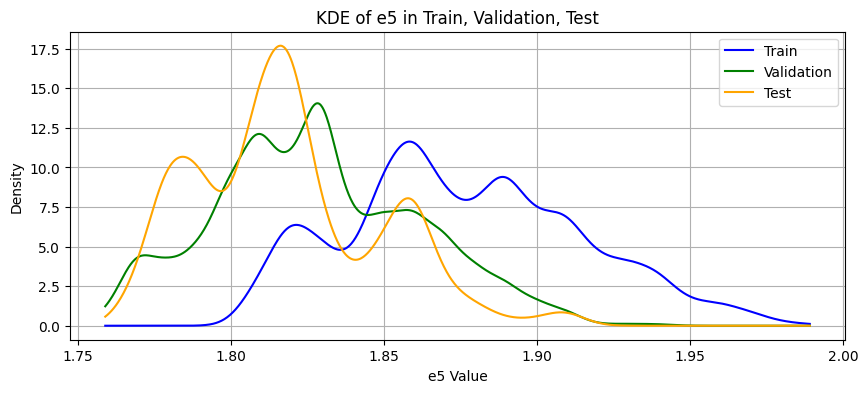

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-06-15 00:05:00 to 2024-06-21 00:00:00, to predict 1 day(s)
Test set range: 2024-06-15 00:05:00 to 2024-06-22 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0379 - val_loss: 0.0069
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast MSE: 0.015123473123142835
                     Predicted E5
datetime                         
2024-06-21 00:00:00      1.824971
2024-06-21 00:05:00      1.825050
2024-06-21 00:10:00      1.824004
2024-06-21 00:15:00      1.823342
2024-06-21 00:20:00      1.822927


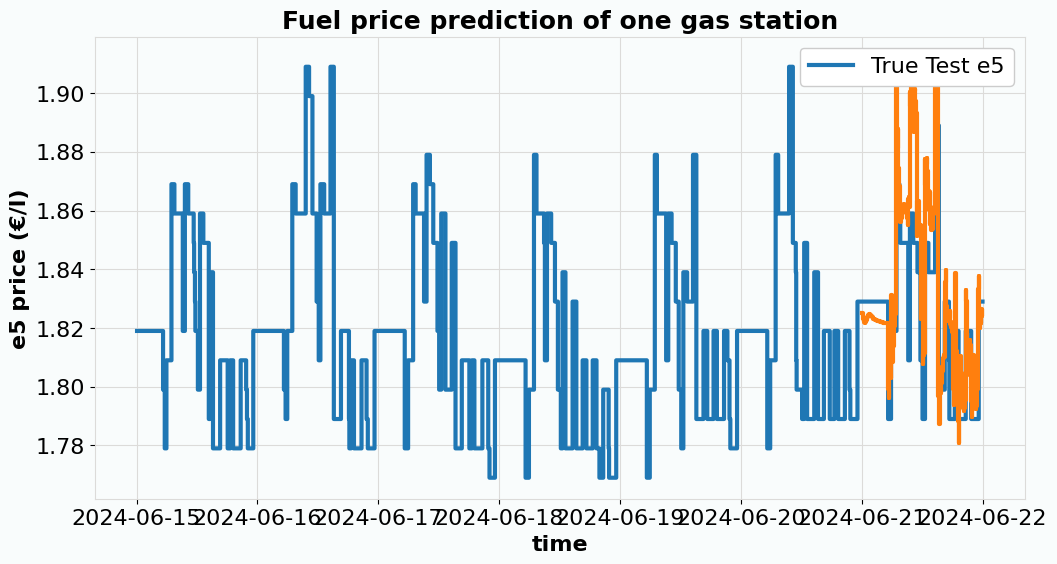

Successfully processed df07

Processing dataset: df08


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


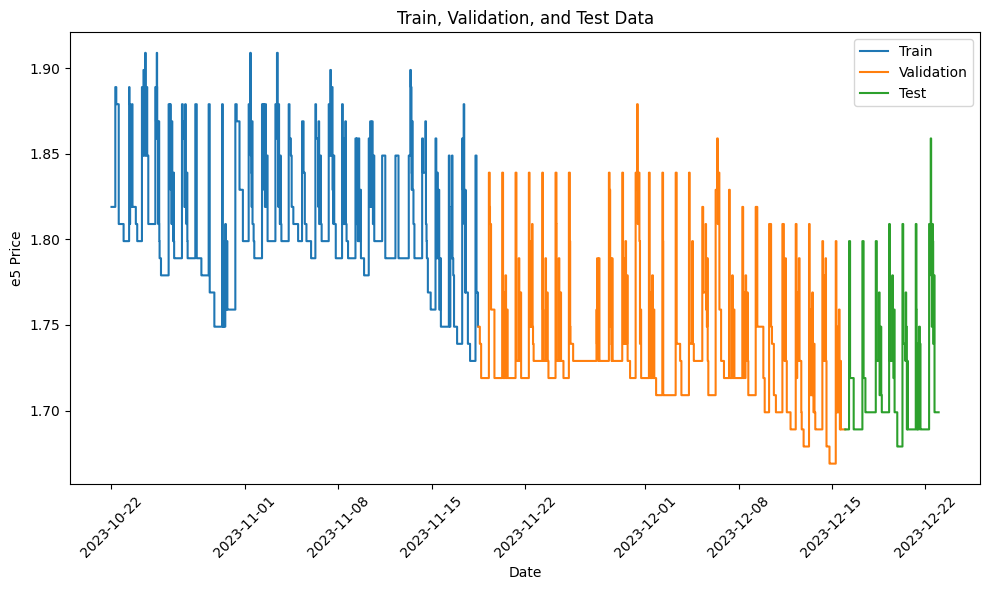

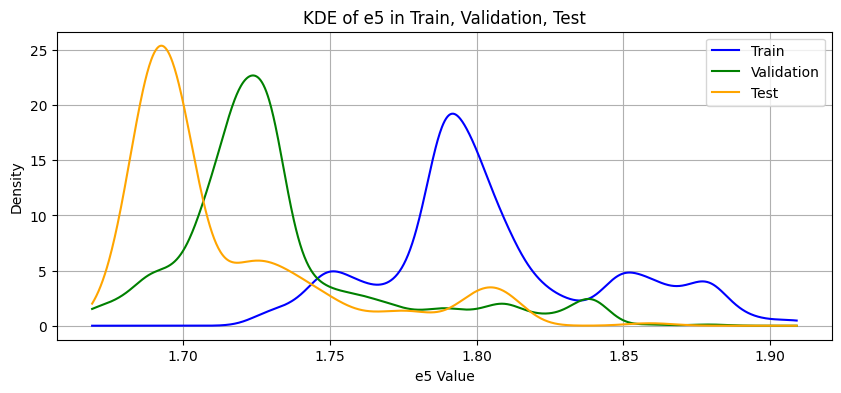

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-16 00:05:00 to 2023-12-22 00:00:00, to predict 1 day(s)
Test set range: 2023-12-16 00:05:00 to 2023-12-23 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0270 - val_loss: 0.0088
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0065
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0072
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0063
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0079
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0024 - val_loss: 0.0079
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.03373378838270178
                     Predicted E5
datetime                         
2023-12-22 00:00:00      1.720531
2023-12-22 00:05:00      1.720526
2023-12-22 00:10:00      1.720531
2023-12-22 00:15:00      1.720524
2023-12-22 00:20:00      1.720528


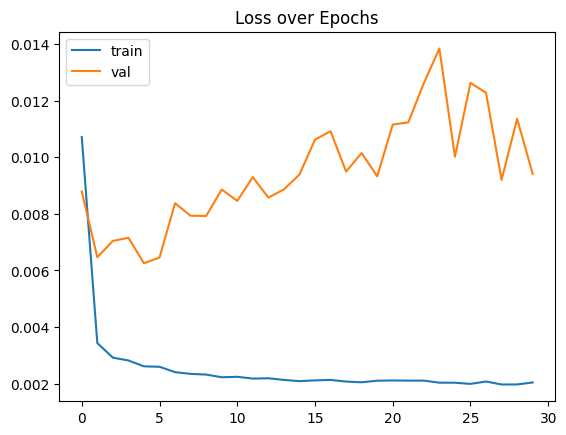

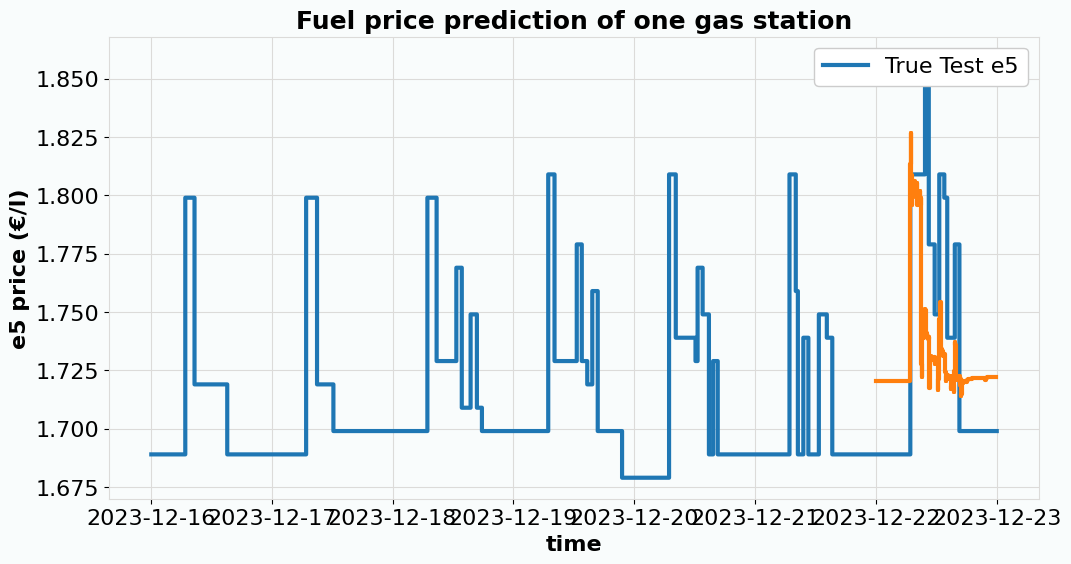

Successfully processed df08

Processing dataset: df09


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


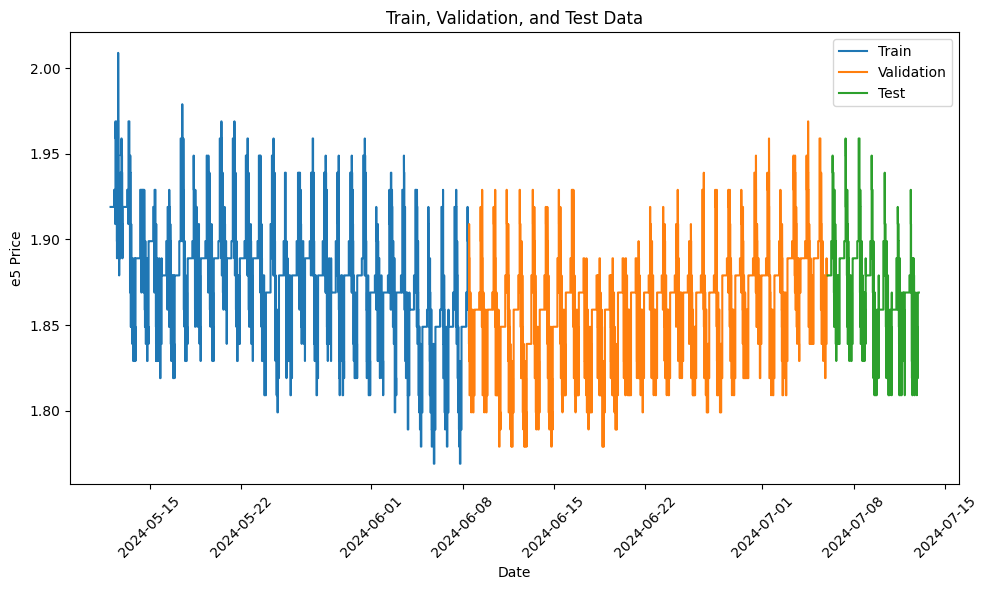

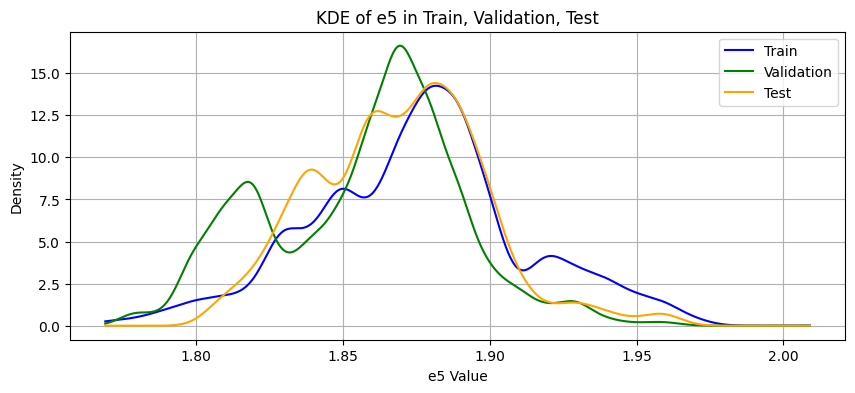

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-07-06 00:05:00 to 2024-07-12 00:00:00, to predict 1 day(s)
Test set range: 2024-07-06 00:05:00 to 2024-07-13 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0190 - val_loss: 0.0034
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 1016s 4s/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.025789981463717044
                     Predicted E5
datetime                         
2024-07-12 00:00:00      1.883865
2024-07-12 00:05:00      1.883293
2024-07-12 00:10:00      1.884519
2024-07-12 00:15:00      1.883179
2024-07-12 00:20:00      1.885774


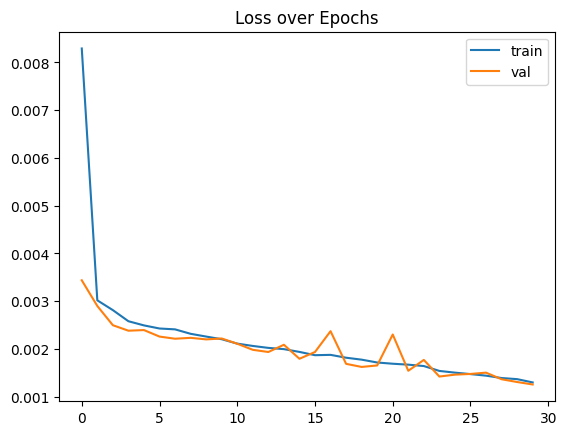

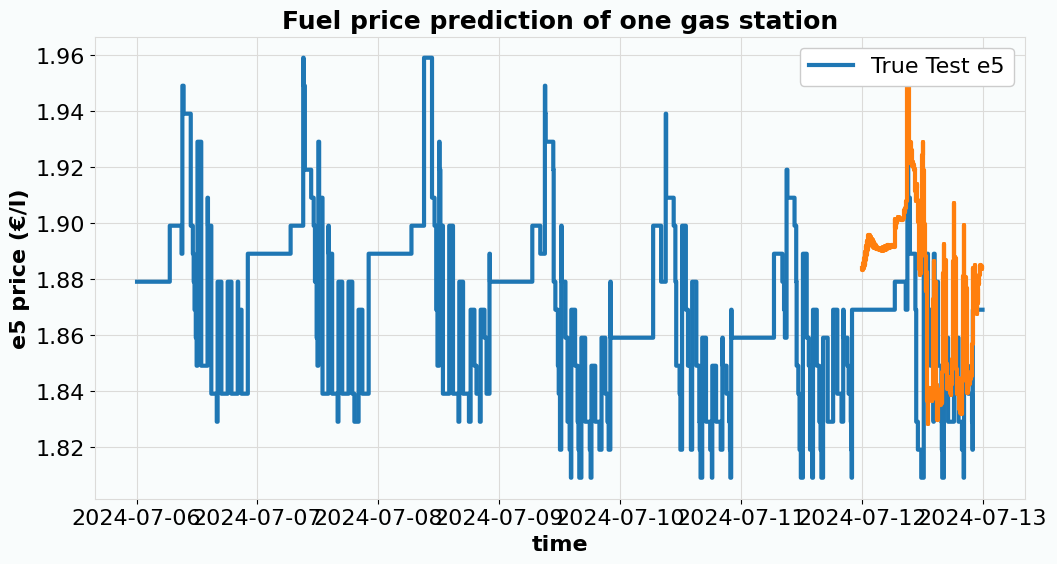

Successfully processed df09

Processing dataset: df10


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


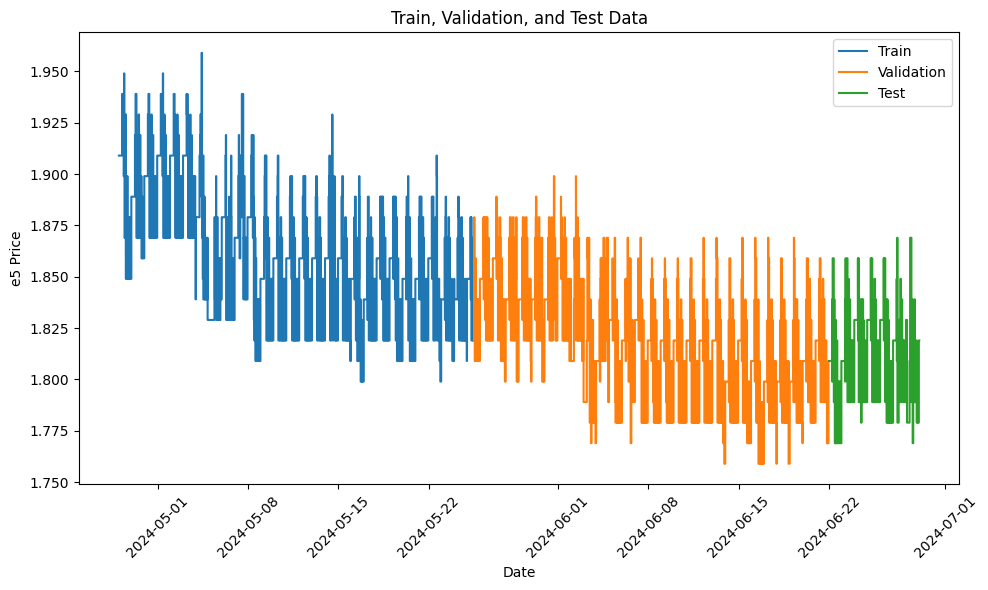

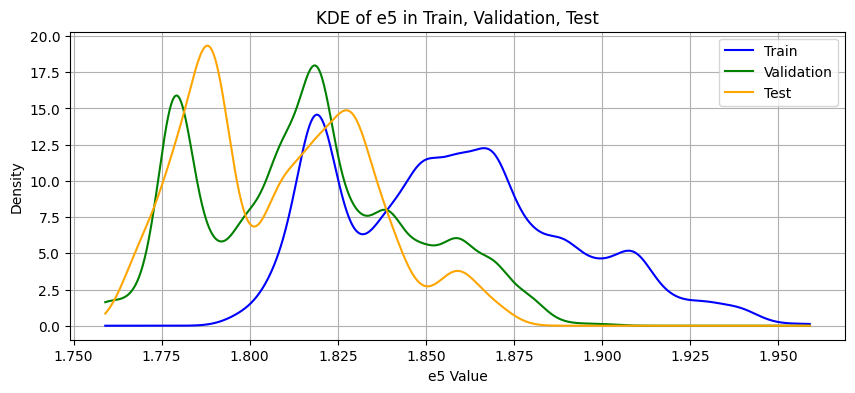

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-06-22 00:05:00 to 2024-06-28 00:00:00, to predict 1 day(s)
Test set range: 2024-06-22 00:05:00 to 2024-06-29 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0214 - val_loss: 0.0073
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 936s 4s/step - loss: 0.0043 - val_loss: 0.0052
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0065
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 935s 4s/step - loss: 0.0036 - val_loss: 0.0050
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.023465391569253466
                     Predicted E5
datetime                         
2024-06-28 00:00:00      1.806282
2024-06-28 00:05:00      1.806332
2024-06-28 00:10:00      1.806384
2024-06-28 00:15:00      1.806724
2024-06-28 00:20:00      1.806801


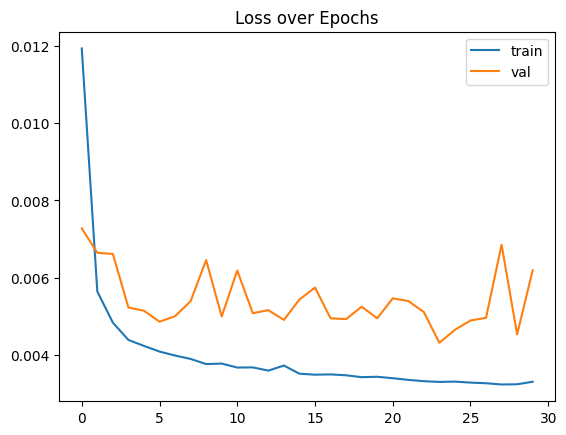

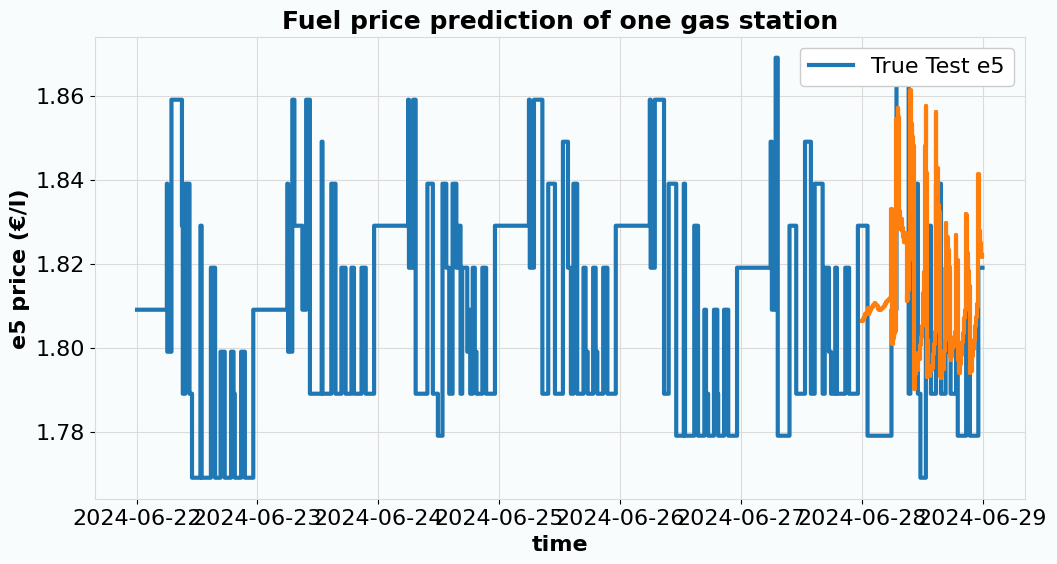

Successfully processed df10

Processing dataset: df11


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


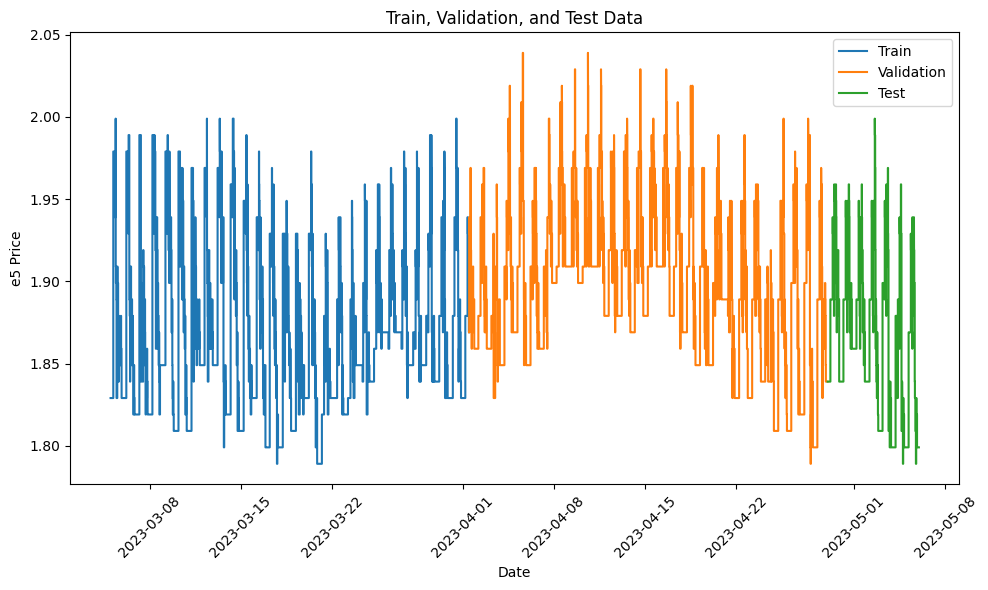

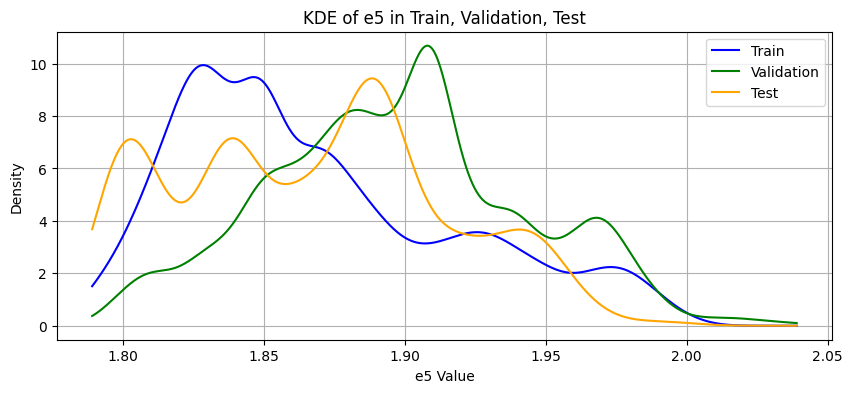

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-04-29 00:05:00 to 2023-05-05 00:00:00, to predict 1 day(s)
Test set range: 2023-04-29 00:05:00 to 2023-05-06 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0332 - val_loss: 0.0032
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 1010s 4s/step - loss: 0.0034 - val_loss: 0.0027
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.03821717151233713
                     Predicted E5
datetime                         
2023-05-05 00:00:00      1.840134
2023-05-05 00:05:00      1.840507
2023-05-05 00:10:00      1.840276
2023-05-05 00:15:00      1.840633
2023-05-05 00:20:00      1.840444


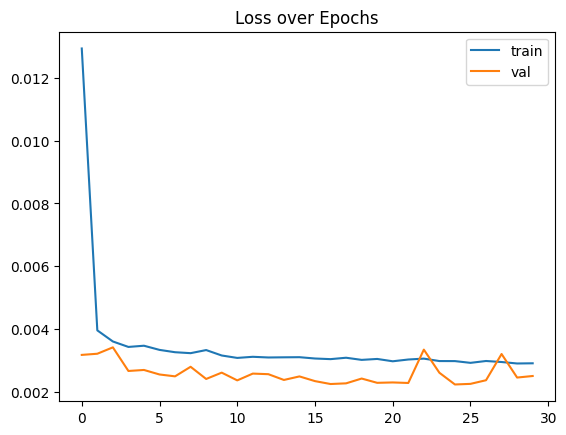

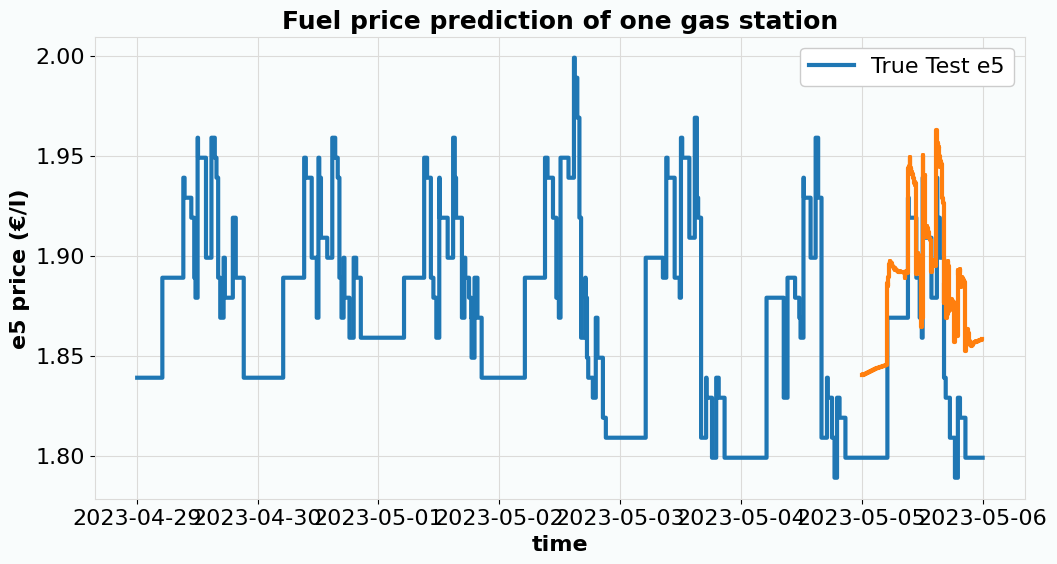

Successfully processed df11

Processing dataset: df12


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


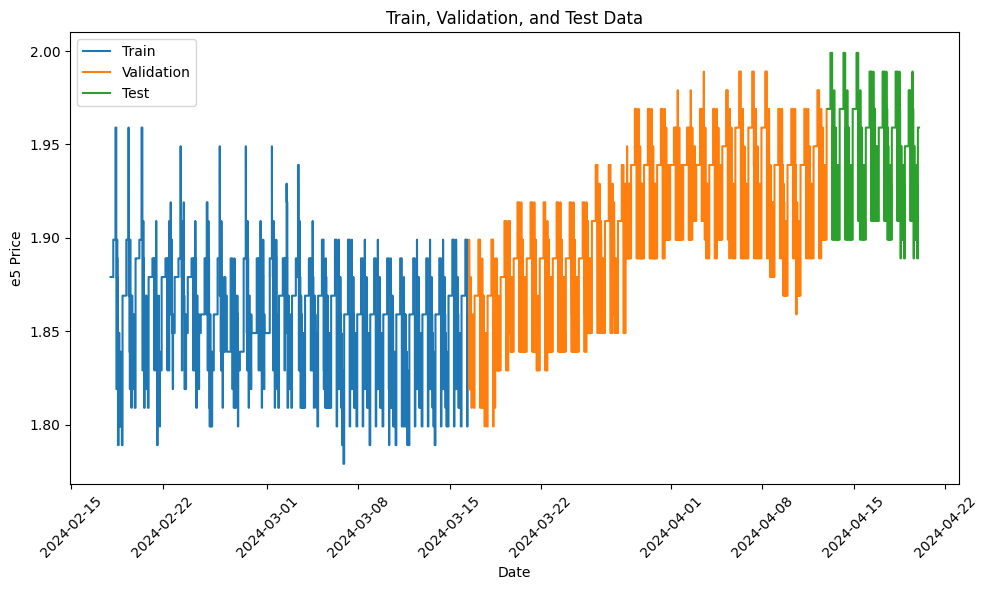

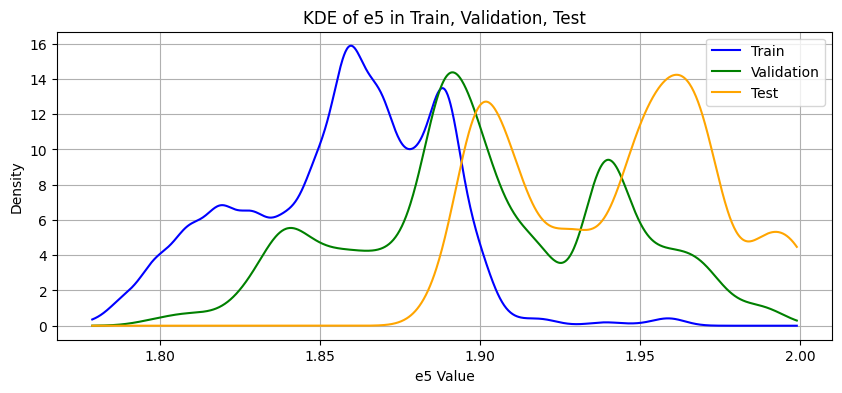

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-04-13 00:05:00 to 2024-04-19 00:00:00, to predict 1 day(s)
Test set range: 2024-04-13 00:05:00 to 2024-04-20 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0261 - val_loss: 0.0094
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0049 - val_loss: 0.0151
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0037 - val_loss: 0.0090
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 1016s 4s/step - loss: 0.0033 - val_loss: 0.0080
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.018007310748928213
                     Predicted E5
datetime                         
2024-04-19 00:00:00      1.948778
2024-04-19 00:05:00      1.948306
2024-04-19 00:10:00      1.948816
2024-04-19 00:15:00      1.948398
2024-04-19 00:20:00      1.948939


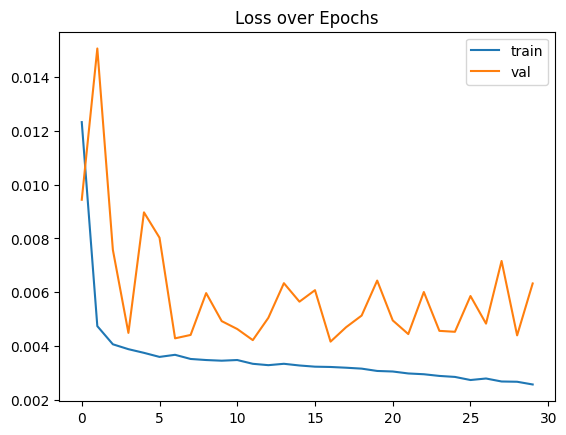

Successfully processed df12

Processing dataset: df13


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


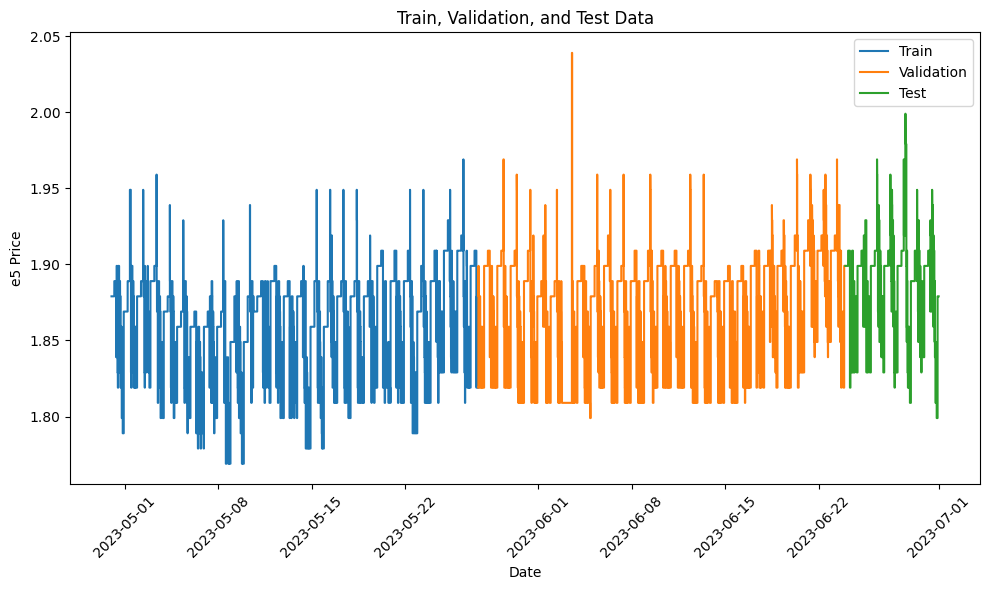

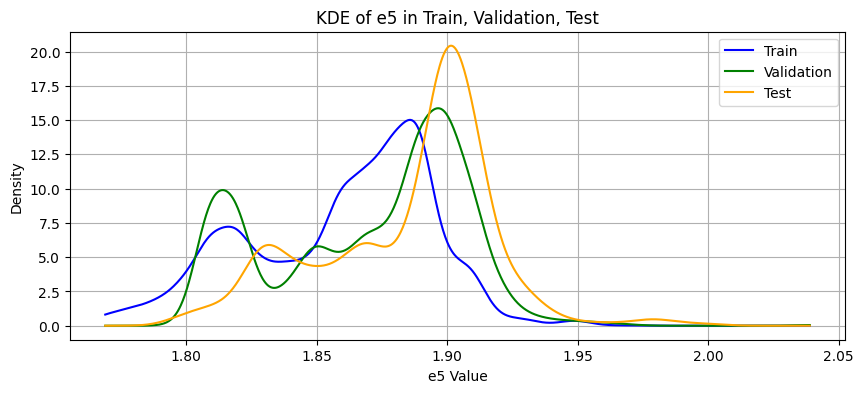

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-06-24 00:05:00 to 2023-06-30 00:00:00, to predict 1 day(s)
Test set range: 2023-06-24 00:05:00 to 2023-07-01 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0314 - val_loss: 0.0043
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - loss: 0.0034 - val_loss: 0.0035
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.016415283940732484
                     Predicted E5
datetime                         
2023-06-30 00:00:00      1.889402
2023-06-30 00:05:00      1.889454
2023-06-30 00:10:00      1.889646
2023-06-30 00:15:00      1.890108
2023-06-30 00:20:00      1.890477


Successfully processed df13

Processing dataset: df14


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


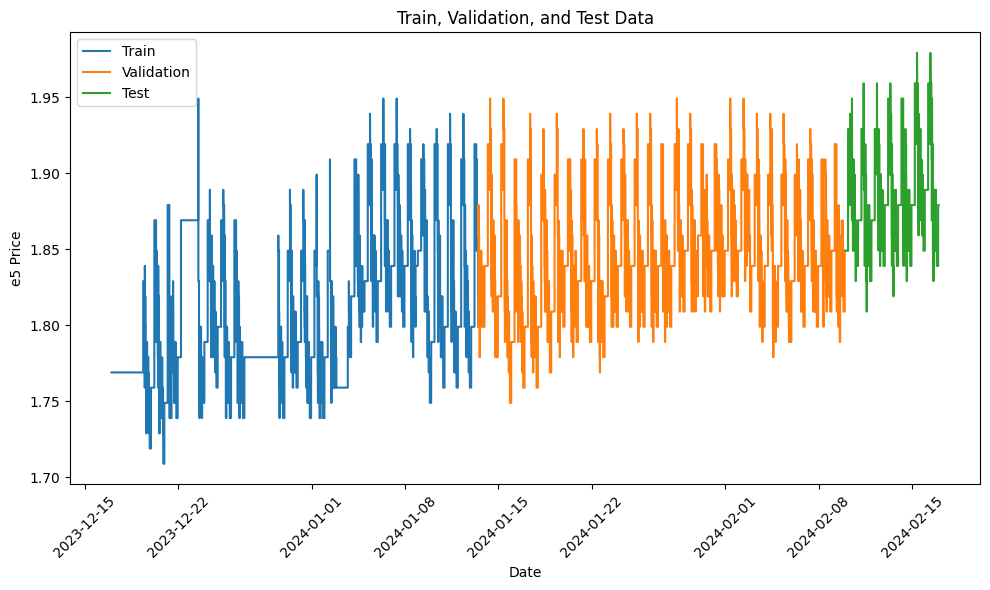

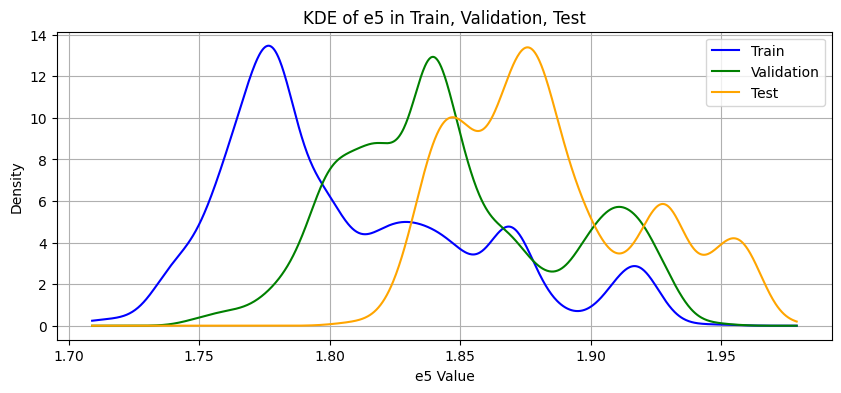

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-02-10 00:05:00 to 2024-02-16 00:00:00, to predict 1 day(s)
Test set range: 2024-02-10 00:05:00 to 2024-02-17 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0117 - val_loss: 0.0032
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast MSE: 0.02329223956498828
                     Predicted E5
datetime                         
2024-02-16 00:00:00      1.868426
2024-02-16 00:05:00      1.869004
2024-02-16 00:10:00      1.869734
2024-02-16 00:15:00      1.869934
2024-02-16 00:20:00      1.870584


Successfully processed df14

Processing dataset: df15


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


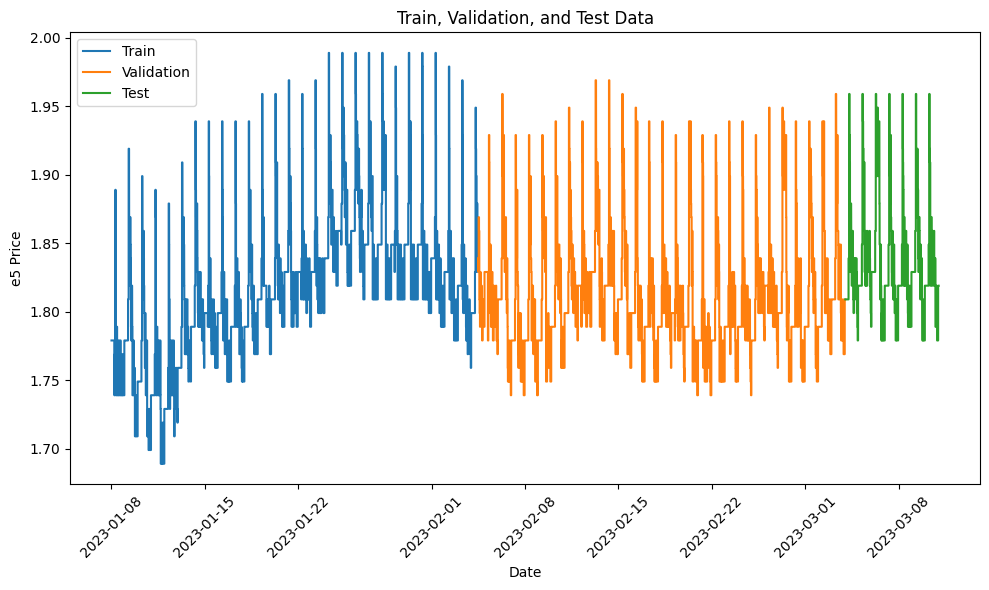

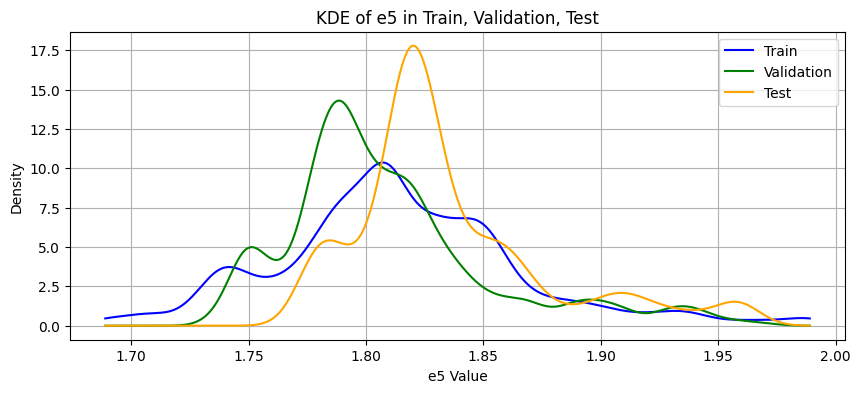

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-03-04 00:05:00 to 2023-03-10 00:00:00, to predict 1 day(s)
Test set range: 2023-03-04 00:05:00 to 2023-03-11 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0185 - val_loss: 0.0029
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecast MSE: 0.017031645025644096
                     Predicted E5
datetime                         
2023-03-10 00:00:00      1.823950
2023-03-10 00:05:00      1.822808
2023-03-10 00:10:00      1.822517
2023-03-10 00:15:00      1.821348
2023-03-10 00:20:00      1.821168


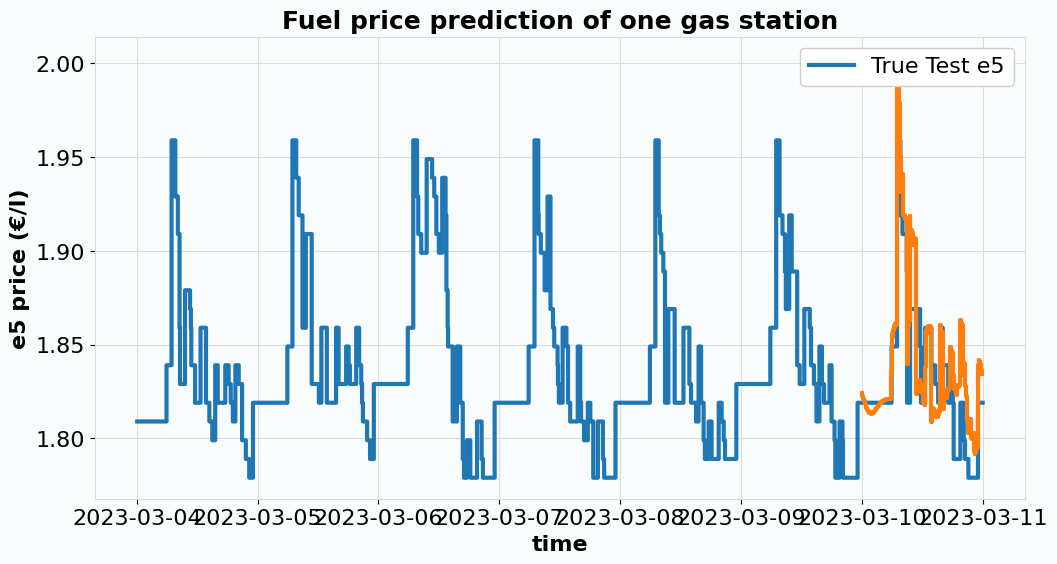

Successfully processed df15

Processing dataset: df16


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


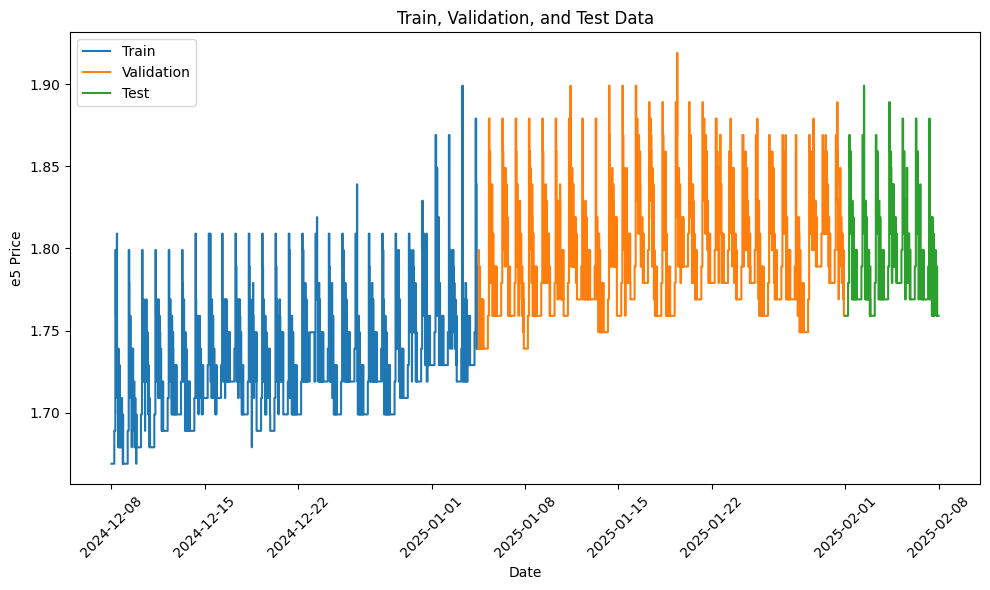

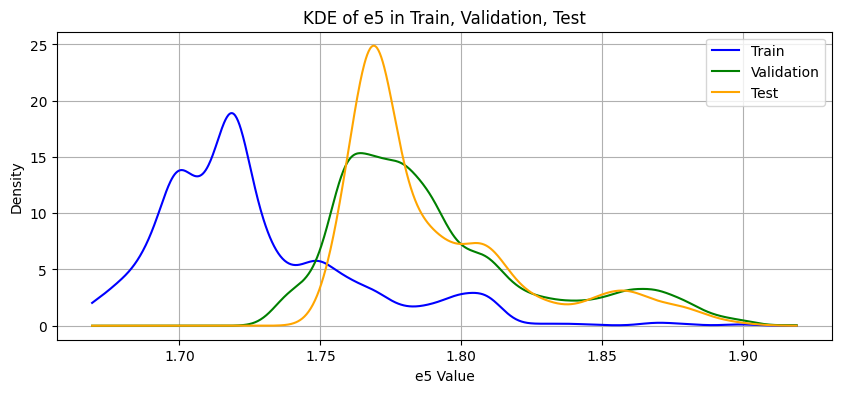

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-02-01 00:05:00 to 2025-02-07 00:00:00, to predict 1 day(s)
Test set range: 2025-02-01 00:05:00 to 2025-02-08 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0139 - val_loss: 0.0040
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 914s 4s/step - loss: 0.0022 - val_loss: 0.0029
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecast MSE: 0.01510650020196205
                     Predicted E5
datetime                         
2025-02-07 00:00:00      1.764216
2025-02-07 00:05:00      1.764065
2025-02-07 00:10:00      1.764413
2025-02-07 00:15:00      1.764267
2025-02-07 00:20:00      1.764730


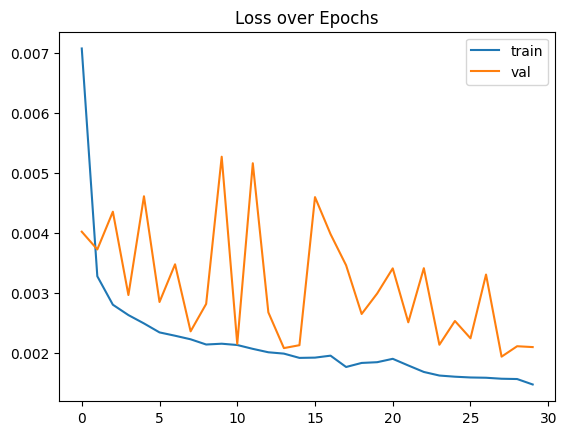

Successfully processed df16

Processing dataset: df17


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


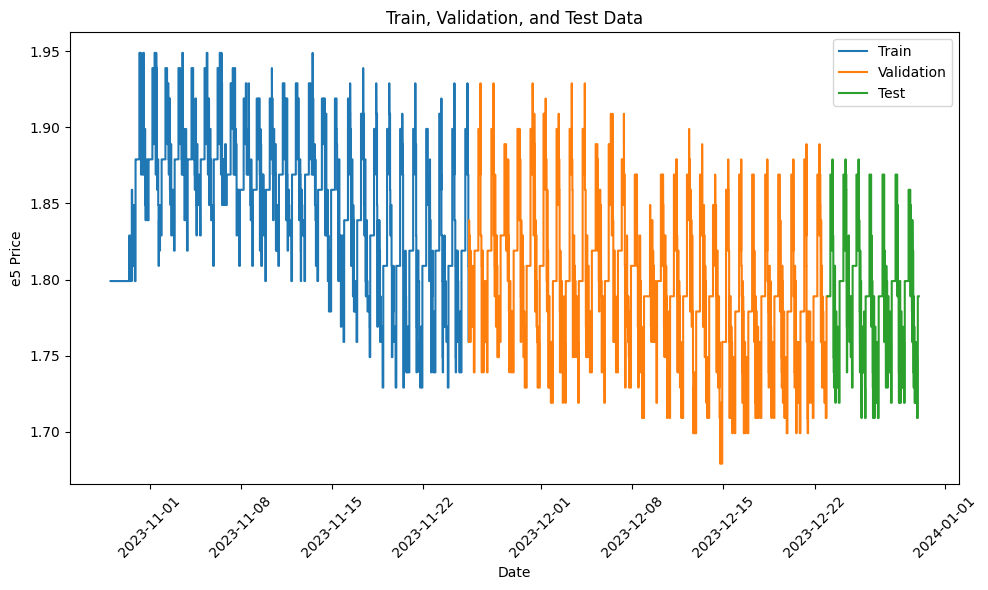

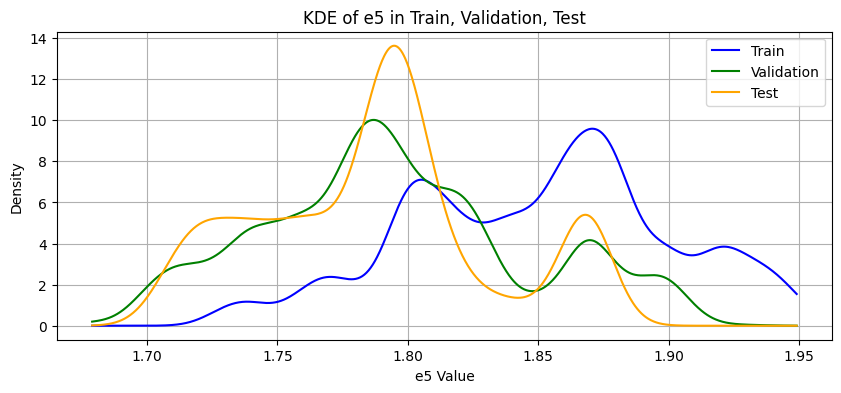

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-23 00:05:00 to 2023-12-29 00:00:00, to predict 1 day(s)
Test set range: 2023-12-23 00:05:00 to 2023-12-30 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 910s 4s/step - loss: 0.0409 - val_loss: 0.0057
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 0.0027 - val_loss: 0.0038
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Forecast MSE: 0.018609630761331715
                     Predicted E5
datetime                         
2023-12-29 00:00:00      1.801090
2023-12-29 00:05:00      1.801267
2023-12-29 00:10:00      1.801136
2023-12-29 00:15:00      1.801262
2023-12-29 00:20:00      1.801172


Successfully processed df17

Processing dataset: df18


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


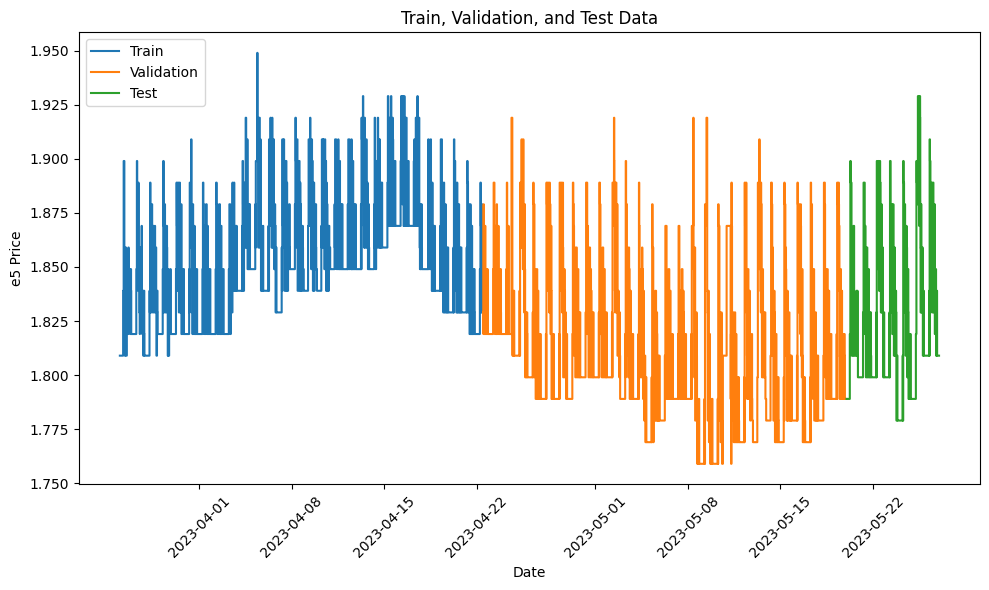

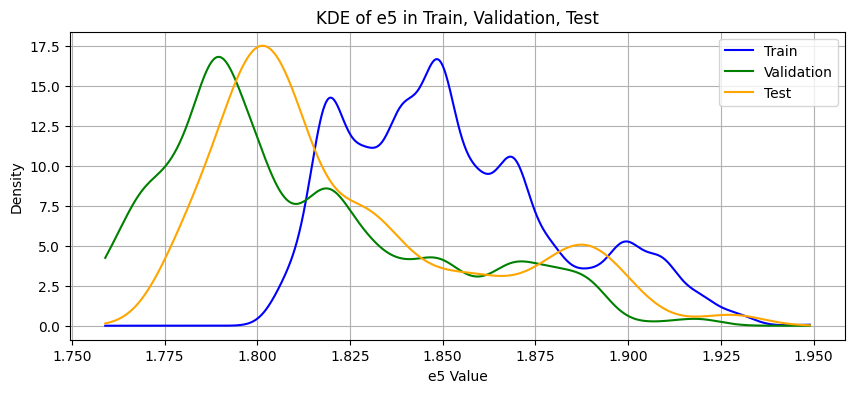

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-05-20 00:05:00 to 2023-05-26 00:00:00, to predict 1 day(s)
Test set range: 2023-05-20 00:05:00 to 2023-05-27 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0133 - val_loss: 0.0173
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0048 - val_loss: 0.0144
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0043 - val_loss: 0.0130
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0038 - val_loss: 0.0116
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0112
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0118
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0036 - val_loss: 0.0091
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0113
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0100
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0099
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.015100312447046092
                     Predicted E5
datetime                         
2023-05-26 00:00:00      1.806868
2023-05-26 00:05:00      1.806905
2023-05-26 00:10:00      1.806886
2023-05-26 00:15:00      1.806890
2023-05-26 00:20:00      1.806896


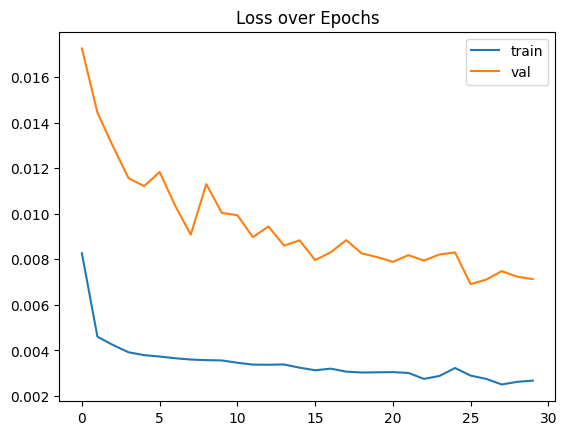

Successfully processed df18

Processing dataset: df19


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


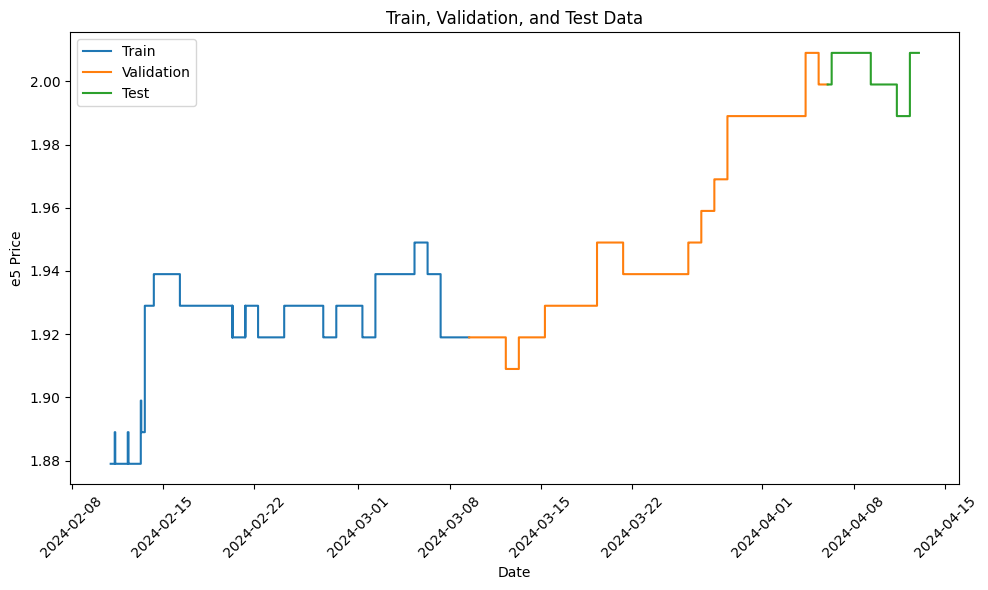

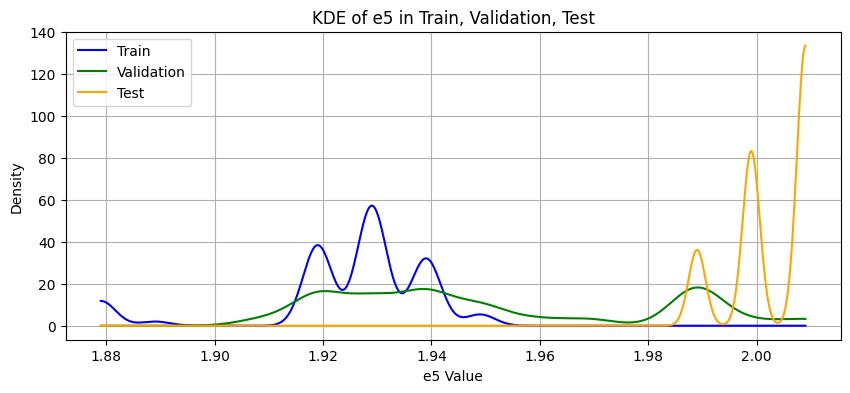

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-04-06 00:05:00 to 2024-04-12 00:00:00, to predict 1 day(s)
Test set range: 2024-04-06 00:05:00 to 2024-04-13 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0328 - val_loss: 0.0063
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 4.1828e-04 - val_loss: 0.0034
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 3.2643e-04 - val_loss: 6.6900e-04
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 4.1233e-04 - val_loss: 3.1616e-04
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 2.6488e-04 - val_loss: 2.9961e-04
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 3.6096e-04 - val_loss: 3.1808e-04
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 2.8606e-04 - val_loss: 3.5813e-04
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 2.9426e-04 - val_loss: 3.4679e-04
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.7628e-04 - val_loss: 3.5803e-04
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.2056e-04 - val_loss: 9.0363e-04
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - los

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.007305321291916766
                     Predicted E5
datetime                         
2024-04-12 00:00:00      2.006961
2024-04-12 00:05:00      2.006961
2024-04-12 00:10:00      2.006961
2024-04-12 00:15:00      2.006961
2024-04-12 00:20:00      2.006961


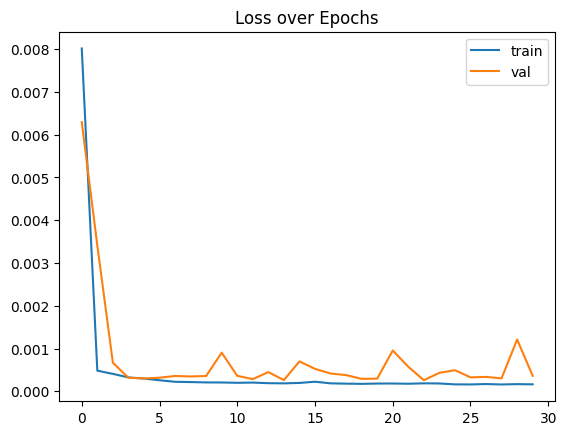

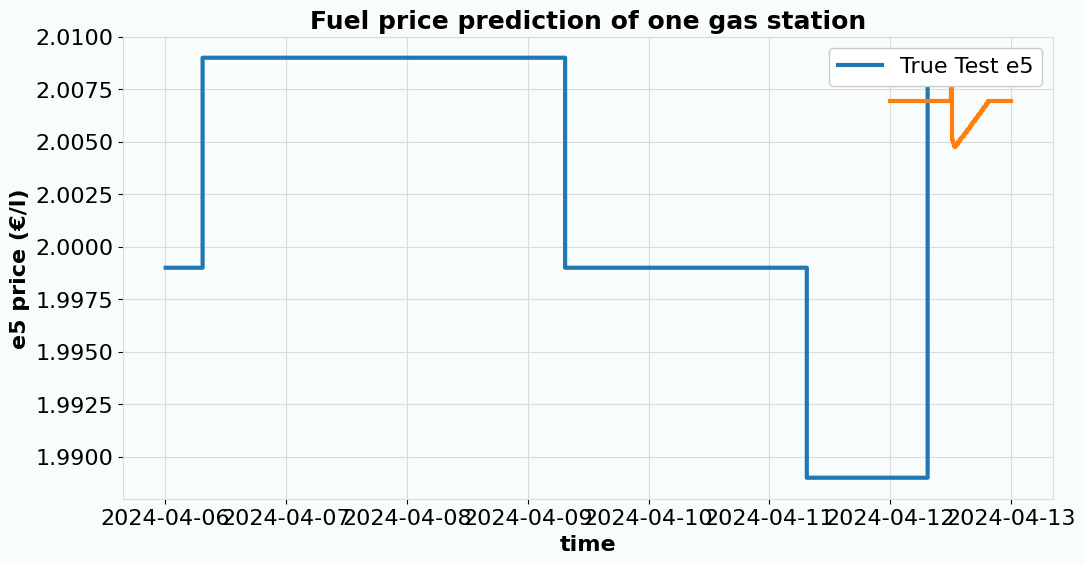

Successfully processed df19

Processing dataset: df20


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


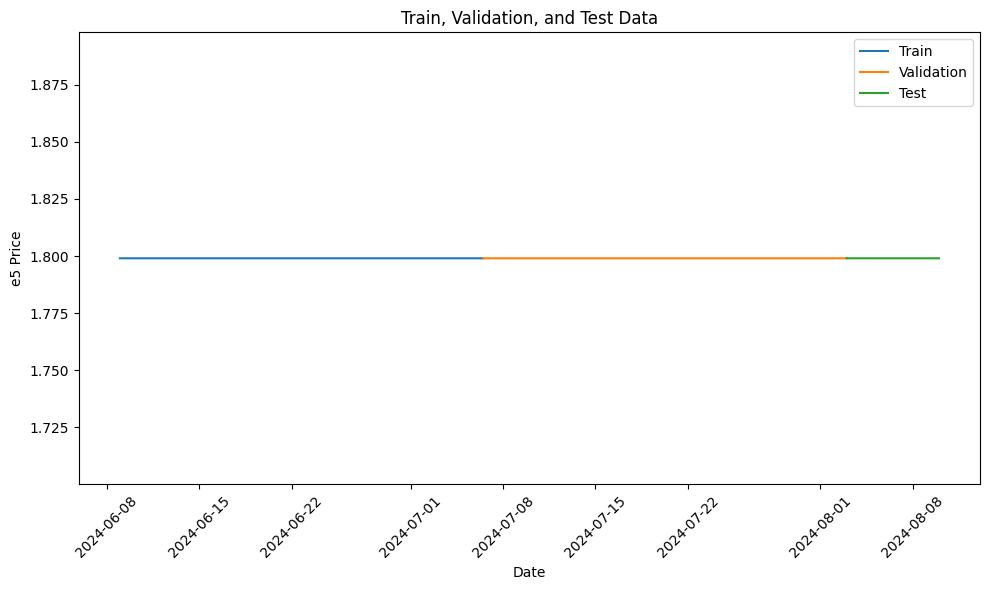

Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

Processing dataset: df21


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


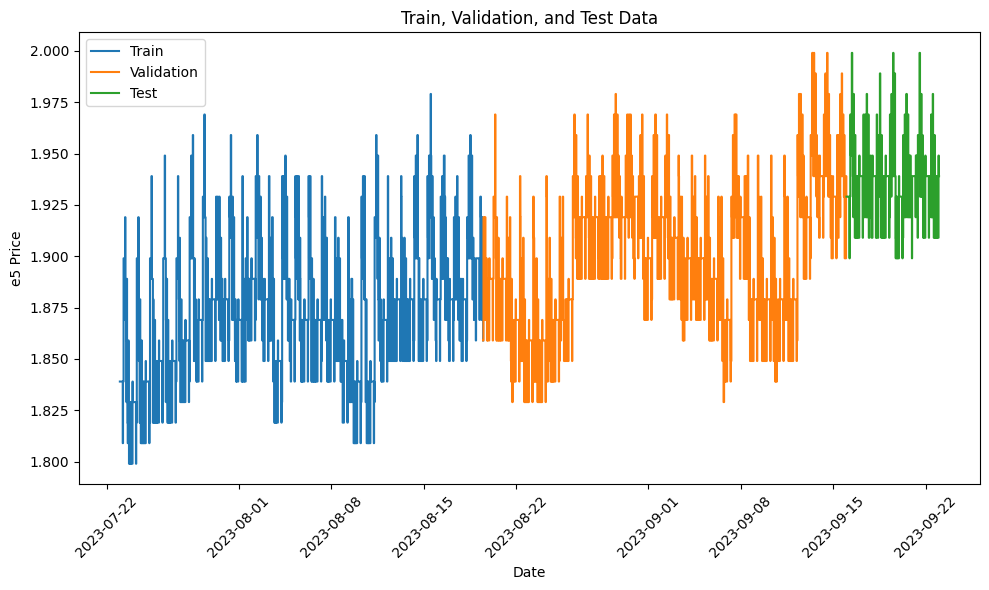

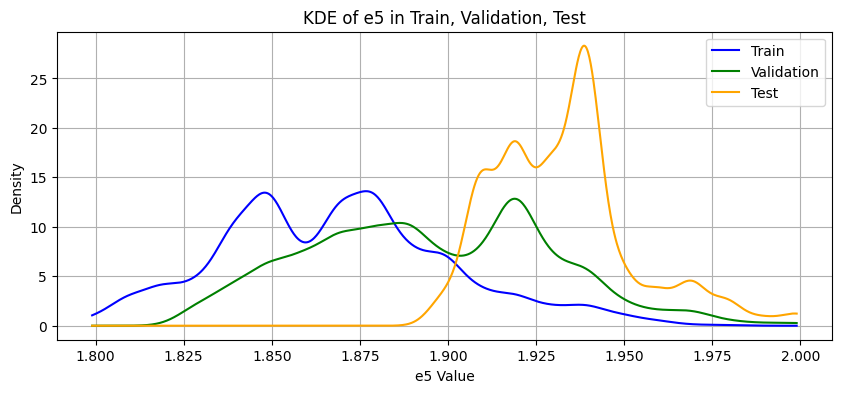

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-09-16 00:05:00 to 2023-09-22 00:00:00, to predict 1 day(s)
Test set range: 2023-09-16 00:05:00 to 2023-09-23 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0273 - val_loss: 0.0053
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast MSE: 0.010992143874367049
                     Predicted E5
datetime                         
2023-09-22 00:00:00      1.930547
2023-09-22 00:05:00      1.929063
2023-09-22 00:10:00      1.930306
2023-09-22 00:15:00      1.929028
2023-09-22 00:20:00      1.929983


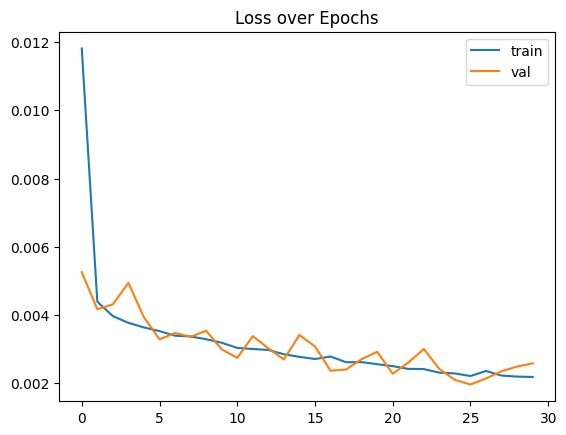

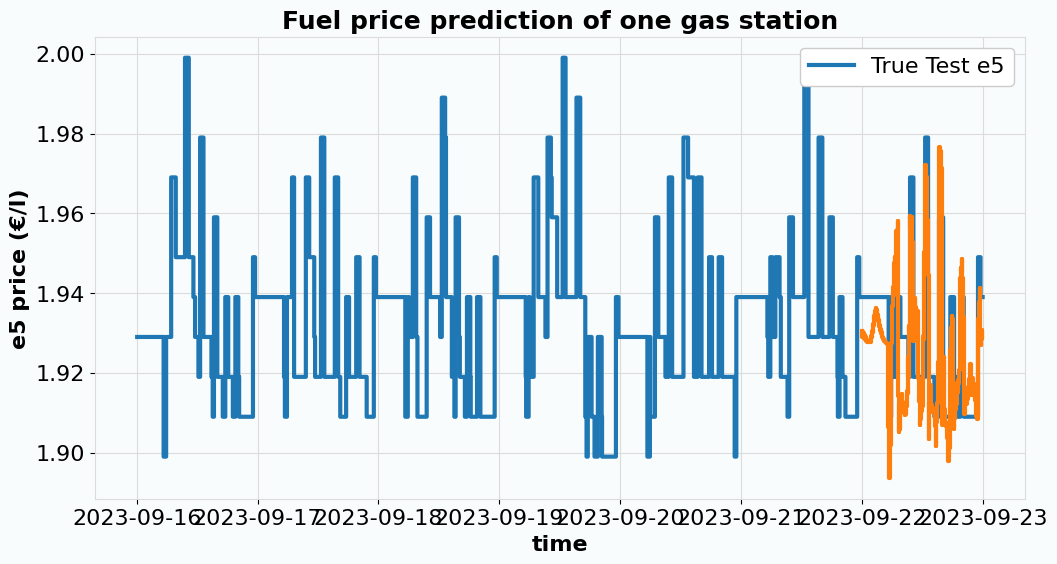

Successfully processed df21

Processing dataset: df22


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


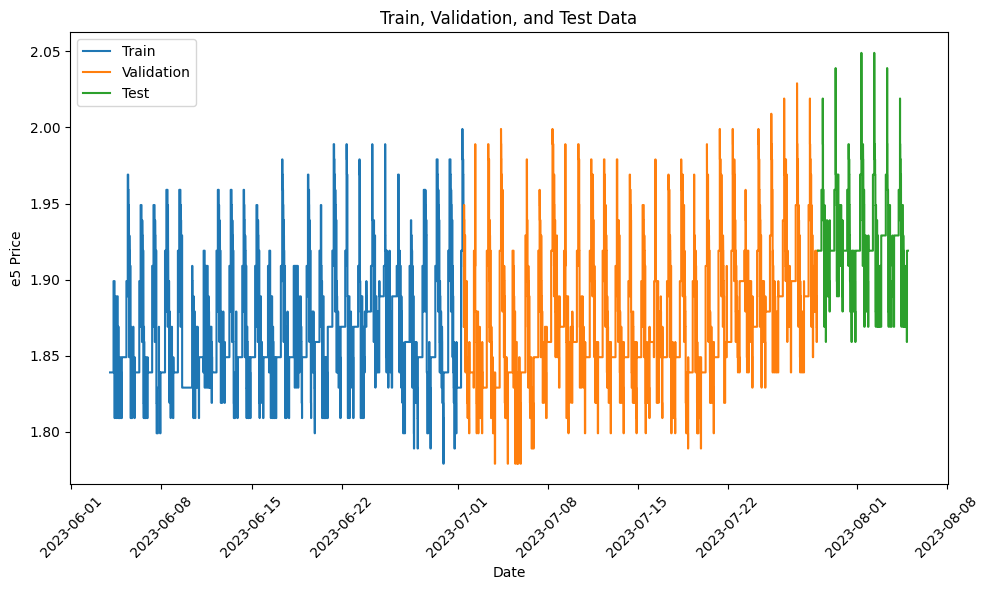

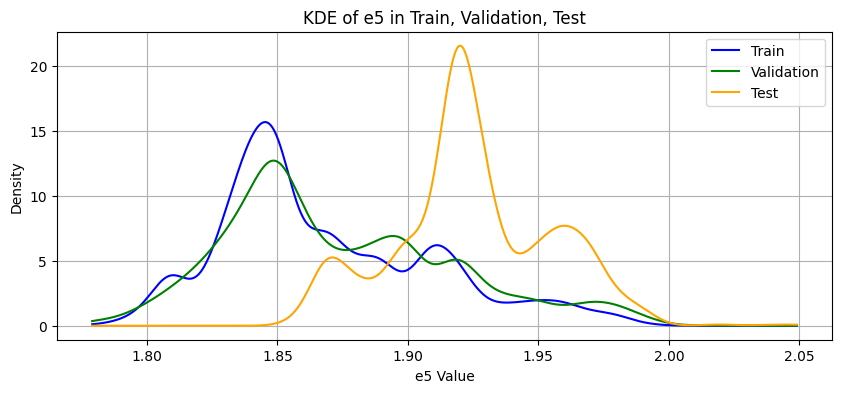

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-07-29 00:05:00 to 2023-08-04 00:00:00, to predict 1 day(s)
Test set range: 2023-07-29 00:05:00 to 2023-08-05 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0245 - val_loss: 0.0038
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.017503016976018762
                     Predicted E5
datetime                         
2023-08-04 00:00:00      1.921504
2023-08-04 00:05:00      1.920234
2023-08-04 00:10:00      1.921156
2023-08-04 00:15:00      1.919876
2023-08-04 00:20:00      1.920925


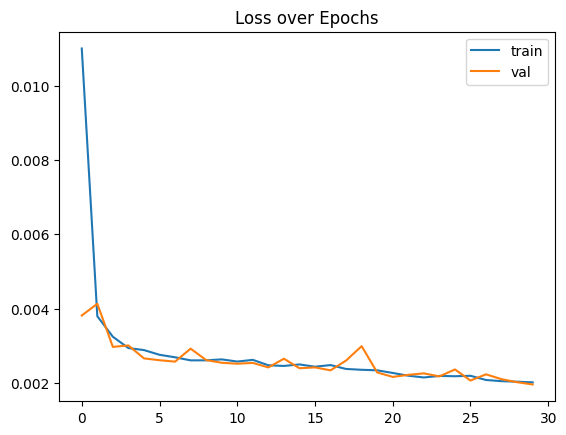

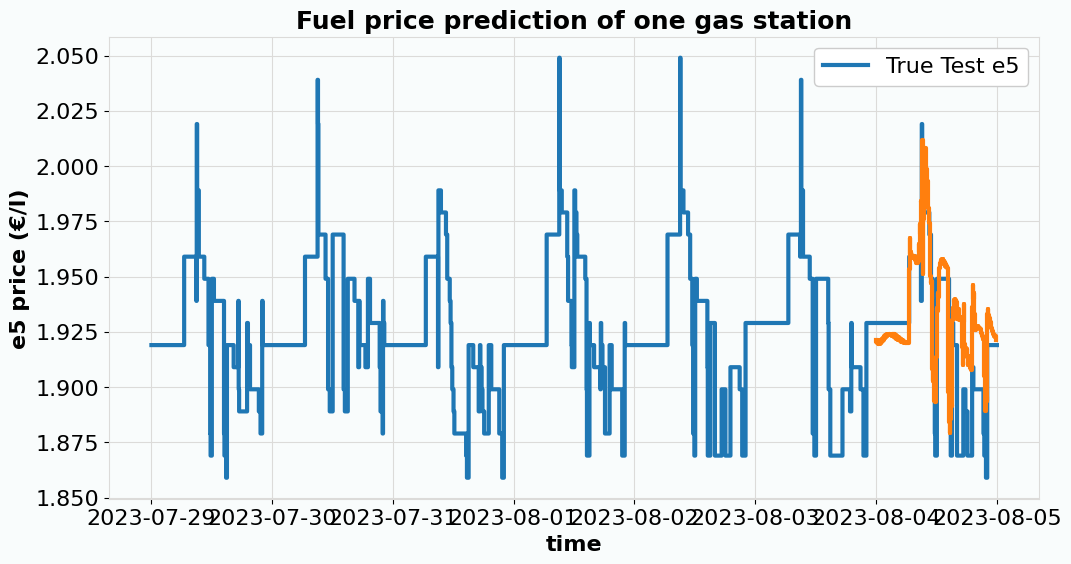

Successfully processed df22

Processing dataset: df23


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


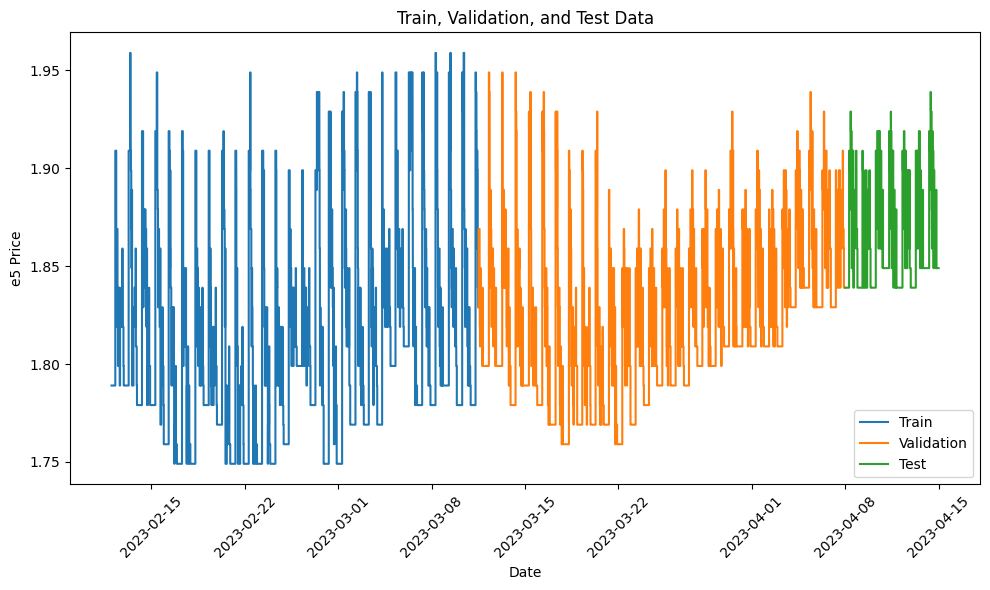

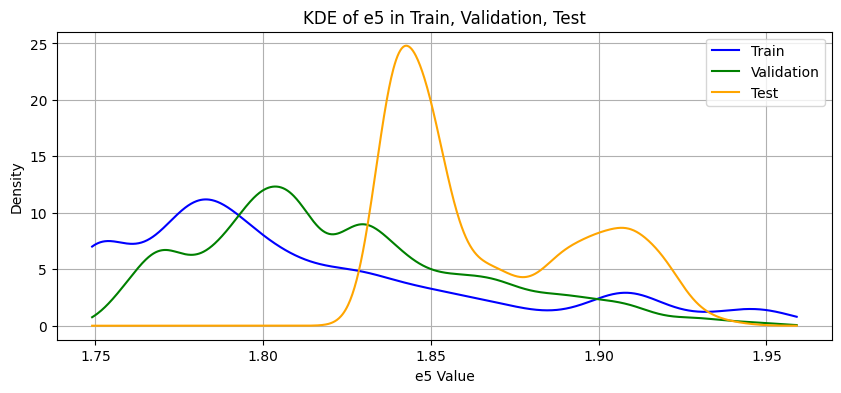

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-04-08 00:05:00 to 2023-04-14 00:00:00, to predict 1 day(s)
Test set range: 2023-04-08 00:05:00 to 2023-04-15 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0278 - val_loss: 0.0041
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Forecast MSE: 0.015034981454825954
                     Predicted E5
datetime                         
2023-04-14 00:00:00      1.837671
2023-04-14 00:05:00      1.837664
2023-04-14 00:10:00      1.837582
2023-04-14 00:15:00      1.837541
2023-04-14 00:20:00      1.837512


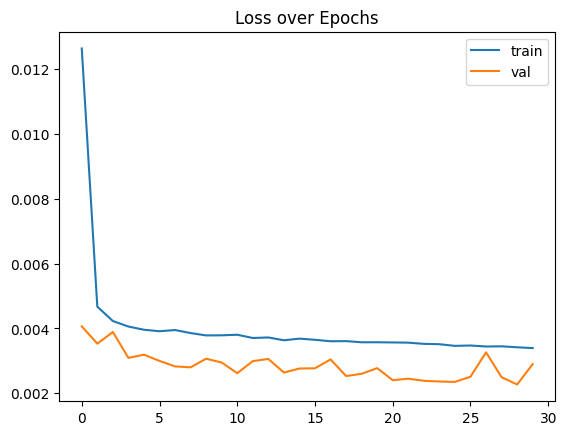

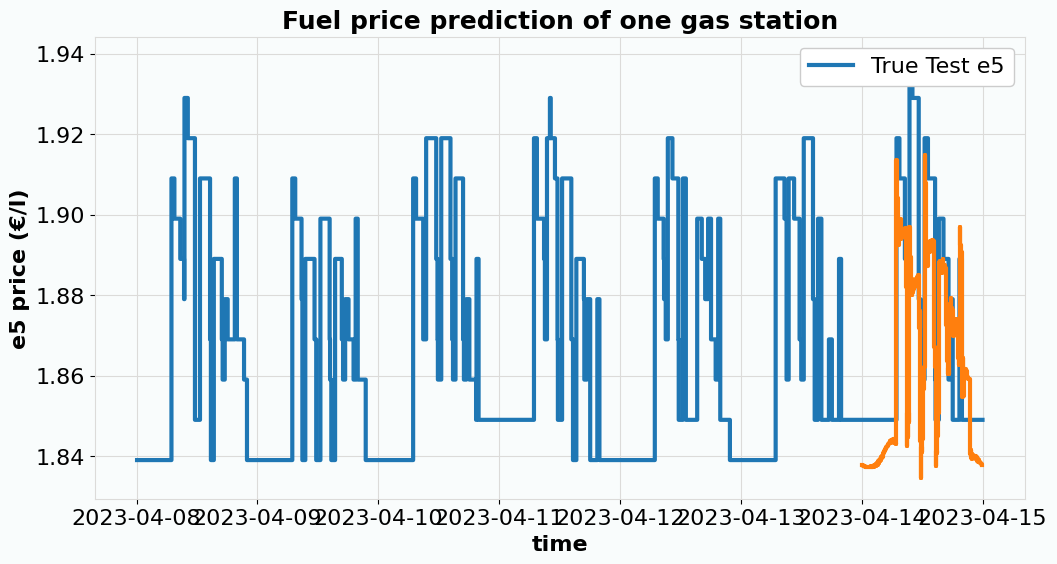

Successfully processed df23

Processing dataset: df24


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


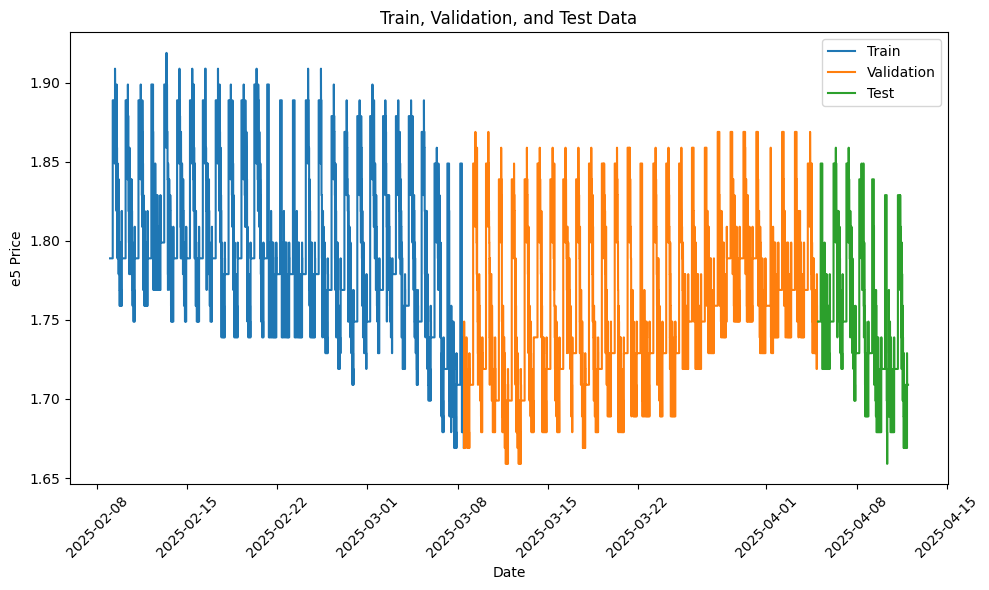

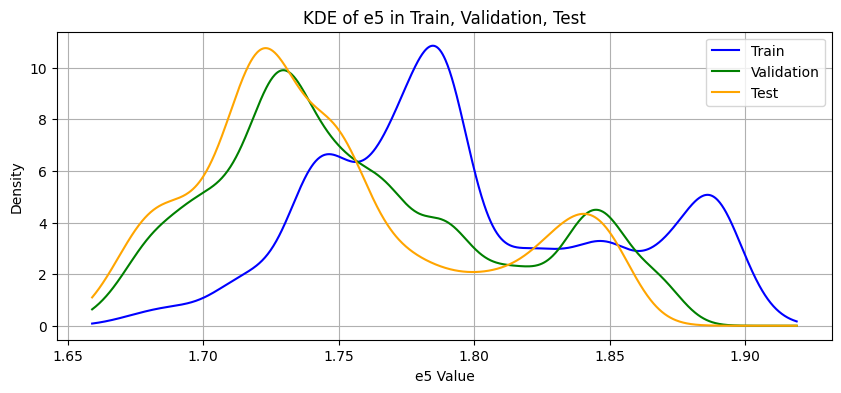

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-04-05 00:05:00 to 2025-04-11 00:00:00, to predict 1 day(s)
Test set range: 2025-04-05 00:05:00 to 2025-04-12 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 0.0196 - val_loss: 0.0038
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 12/30
239/239 ━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecast MSE: 0.044075531332443164
                     Predicted E5
datetime                         
2025-04-11 00:00:00      1.746710
2025-04-11 00:05:00      1.747045
2025-04-11 00:10:00      1.746061
2025-04-11 00:15:00      1.746196
2025-04-11 00:20:00      1.746063


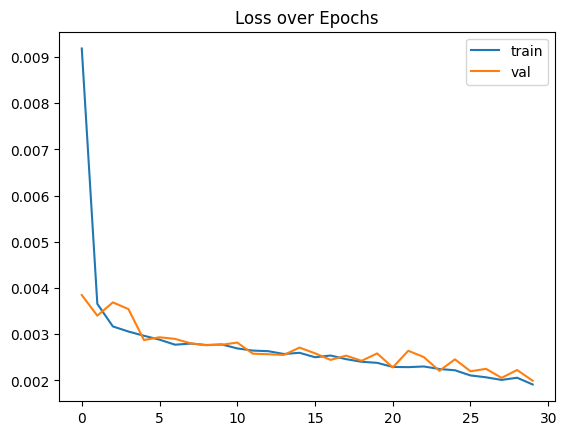

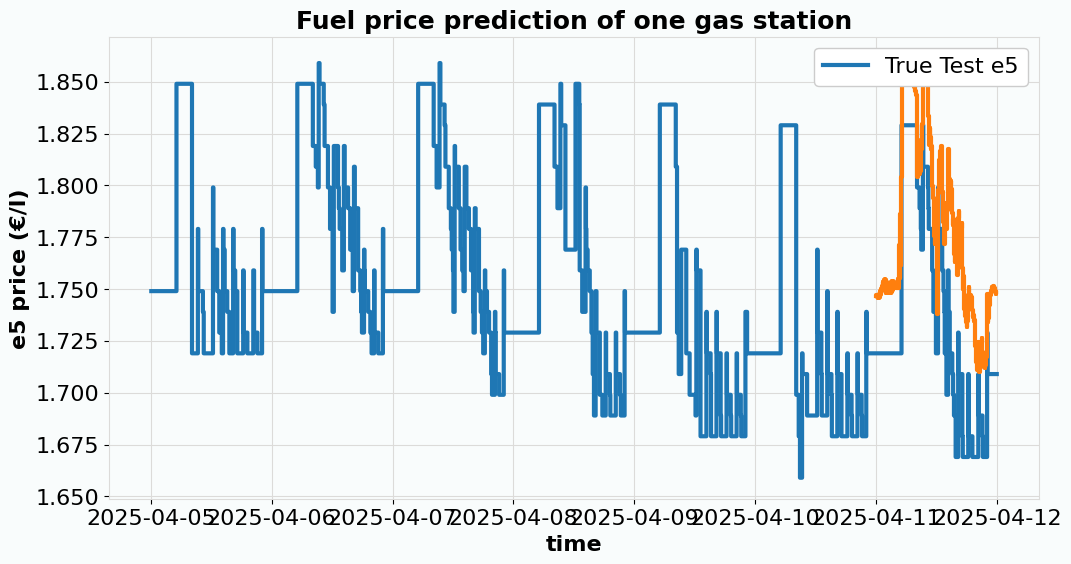

Successfully processed df24

Processing dataset: df25


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


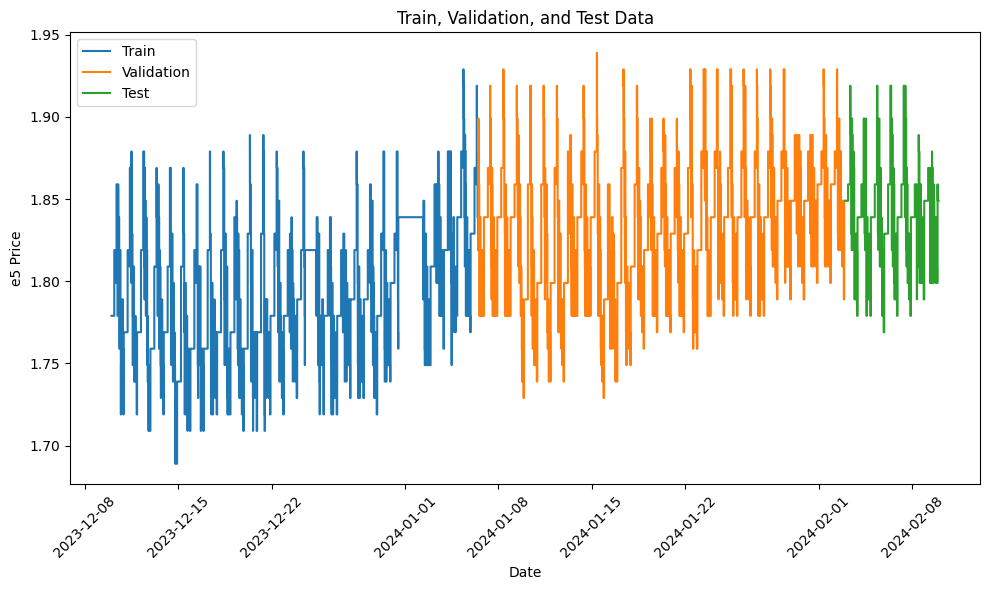

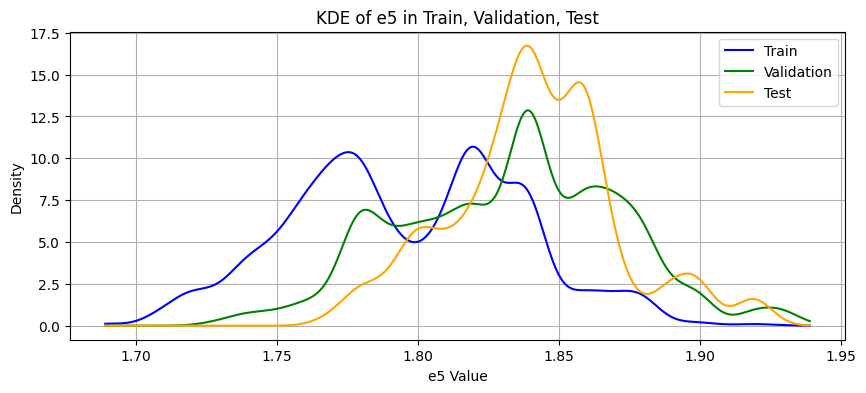

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-02-03 00:05:00 to 2024-02-09 00:00:00, to predict 1 day(s)
Test set range: 2024-02-03 00:05:00 to 2024-02-10 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.0223 - val_loss: 0.0032
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast MSE: 0.016055407168136693
                     Predicted E5
datetime                         
2024-02-09 00:00:00      1.837142
2024-02-09 00:05:00      1.836395
2024-02-09 00:10:00      1.837039
2024-02-09 00:15:00      1.836369
2024-02-09 00:20:00      1.836970


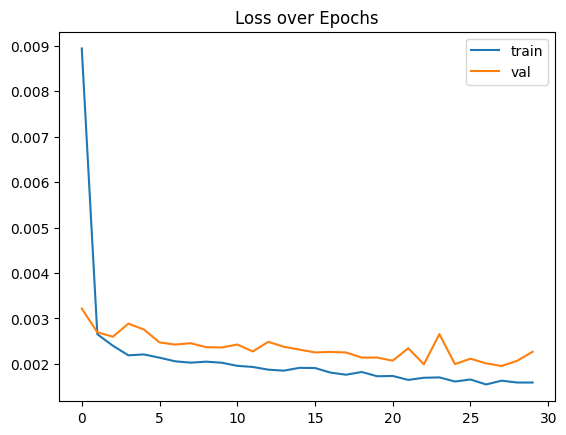

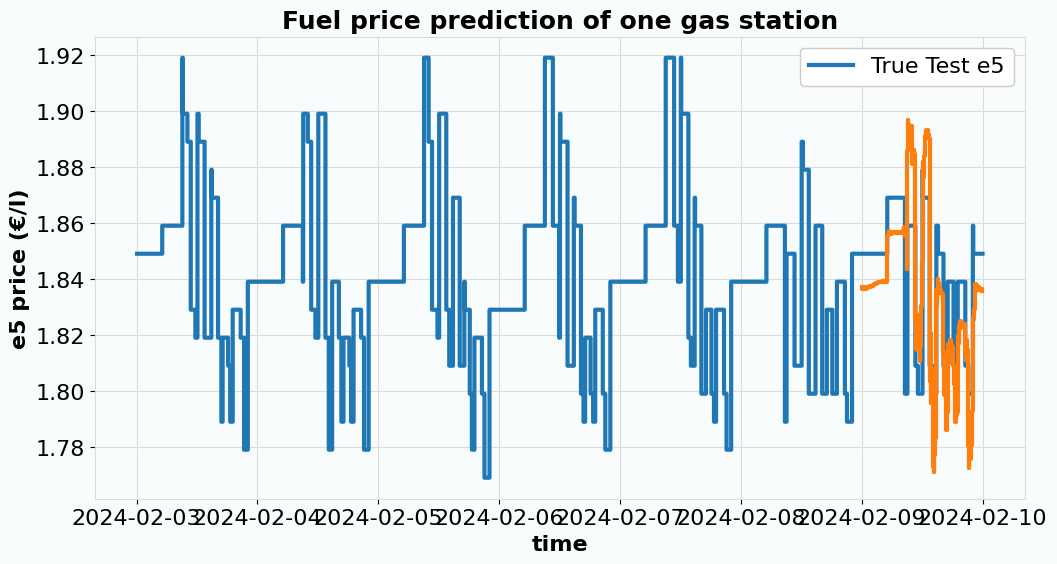

Successfully processed df25

Processing dataset: df26


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


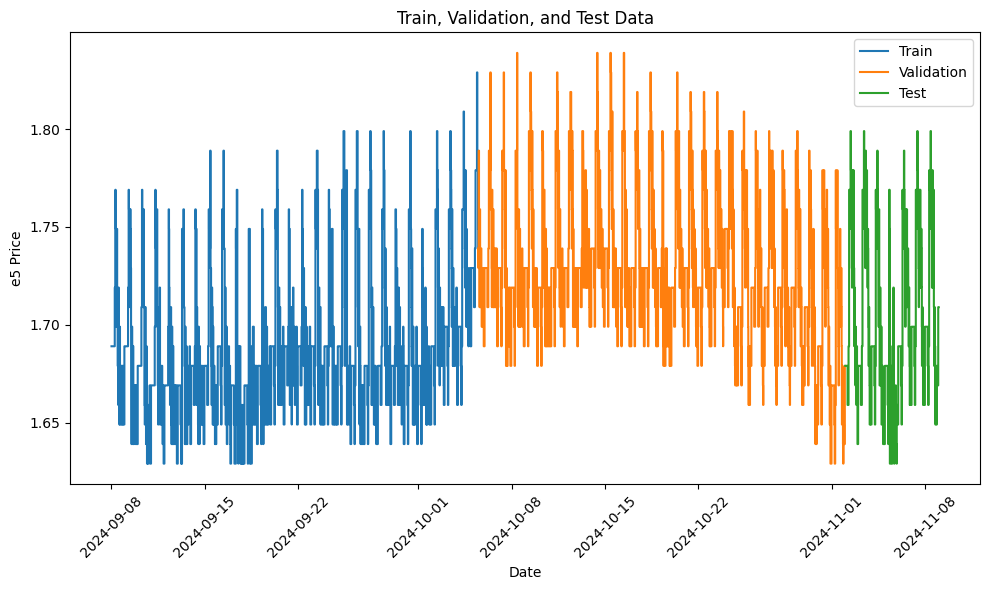

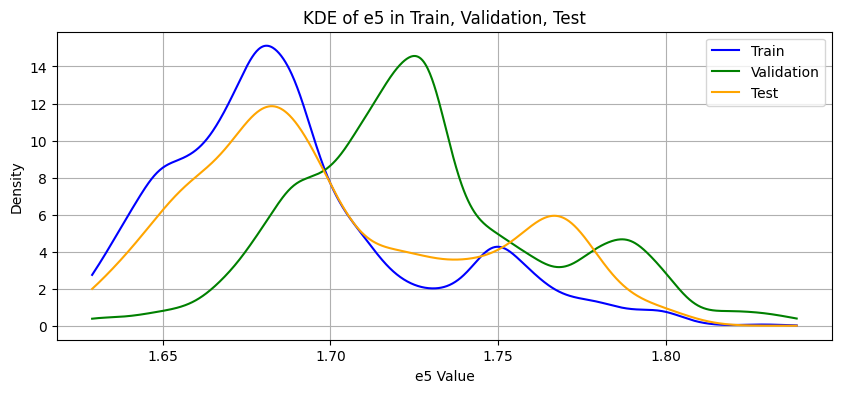

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-11-02 00:05:00 to 2024-11-08 00:00:00, to predict 1 day(s)
Test set range: 2024-11-02 00:05:00 to 2024-11-09 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast MSE: 0.016034569735121393
                     Predicted E5
datetime                         
2024-11-08 00:00:00      1.680545
2024-11-08 00:05:00      1.677799
2024-11-08 00:10:00      1.678881
2024-11-08 00:15:00      1.676806
2024-11-08 00:20:00      1.677027


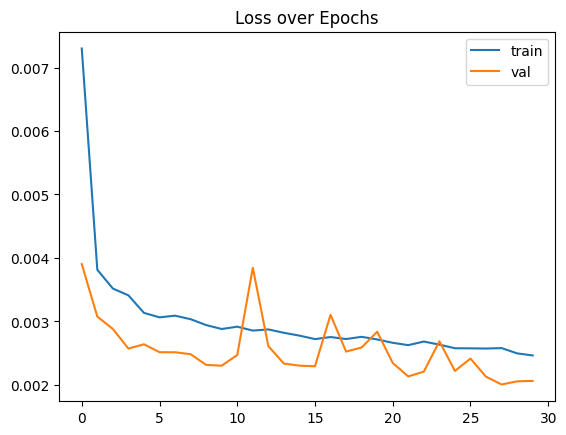

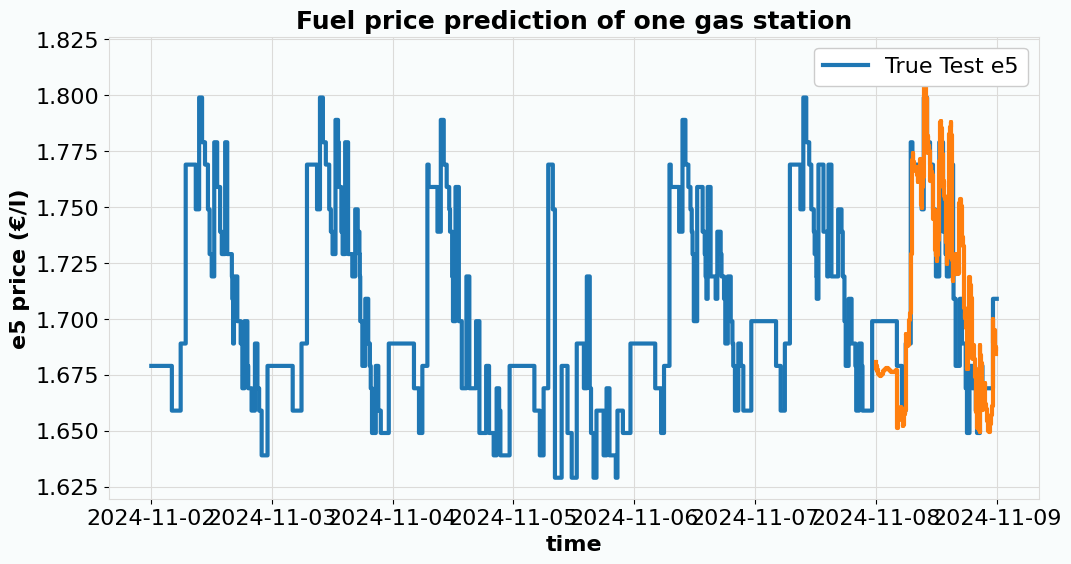

Successfully processed df26

Processing dataset: df27


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


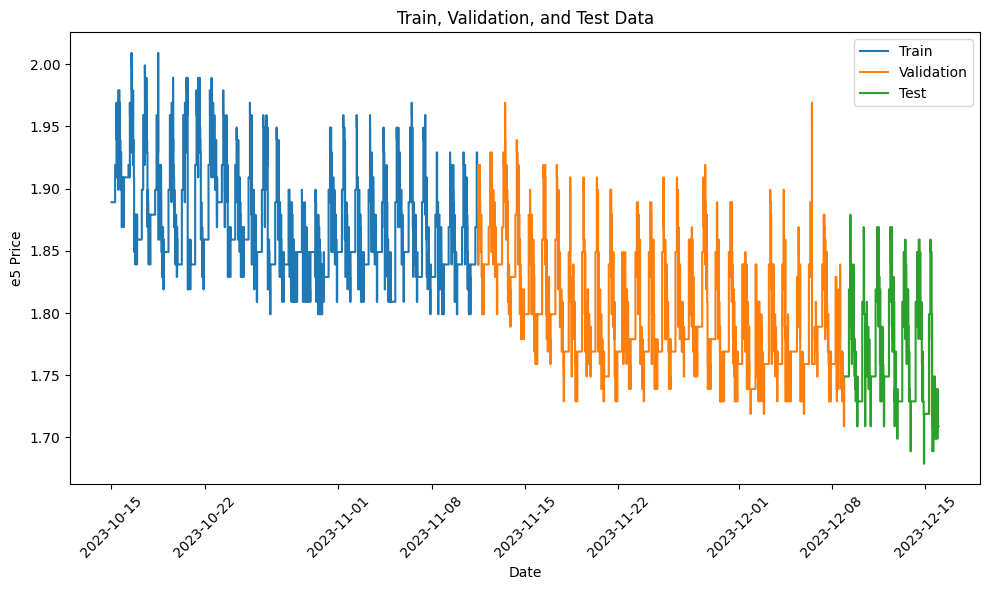

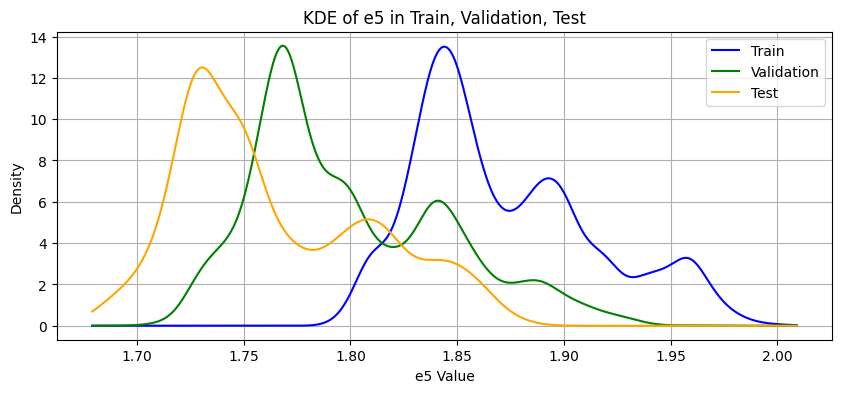

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-09 00:05:00 to 2023-12-15 00:00:00, to predict 1 day(s)
Test set range: 2023-12-09 00:05:00 to 2023-12-16 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0105
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0131
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0116
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0102
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0137
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0095
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0093
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0085
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0102
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Forecast MSE: 0.0679138686304213
                     Predicted E5
datetime                         
2023-12-15 00:00:00      1.795044
2023-12-15 00:05:00      1.794944
2023-12-15 00:10:00      1.794968
2023-12-15 00:15:00      1.794924
2023-12-15 00:20:00      1.794930


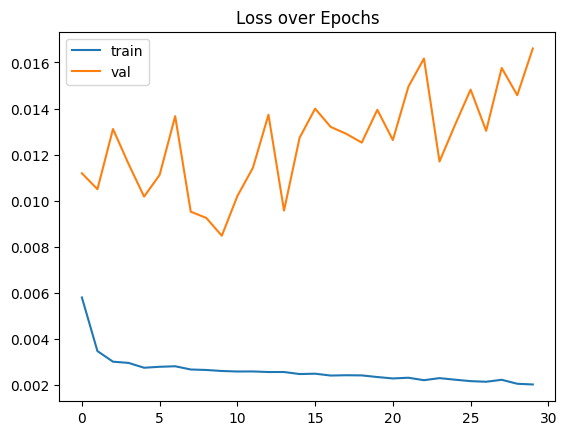

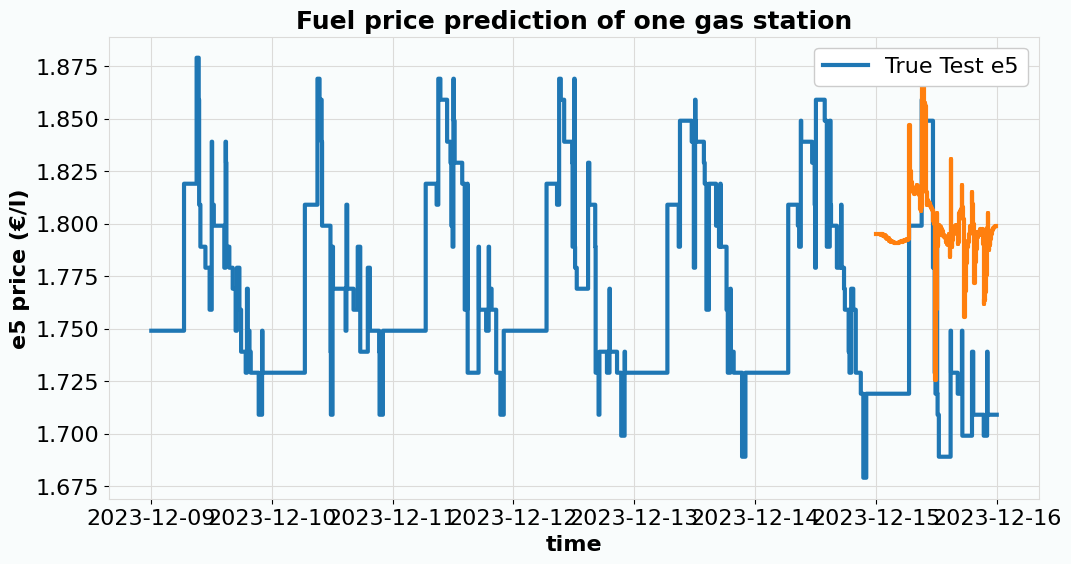

Successfully processed df27

Processing dataset: df28


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


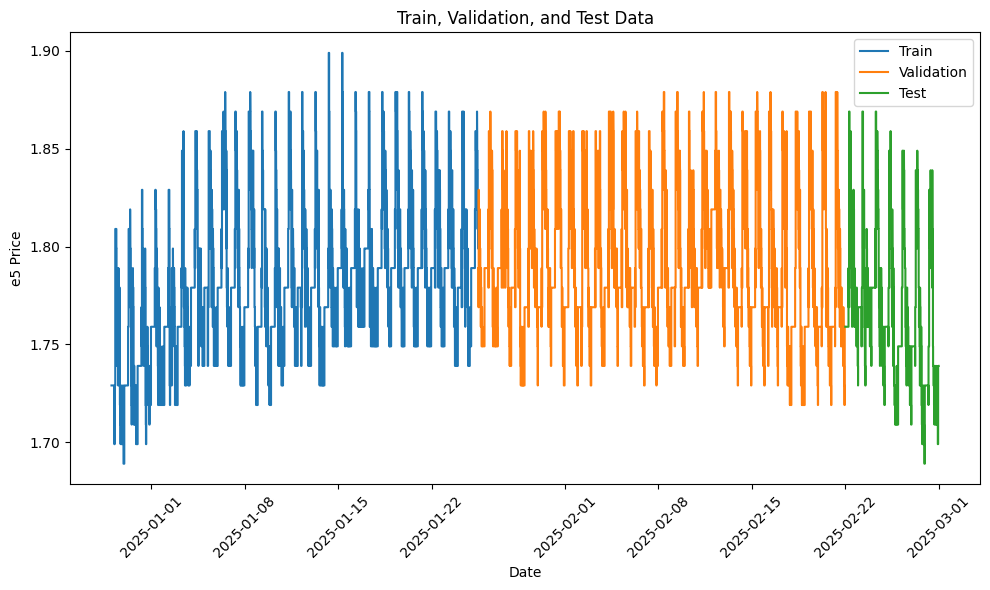

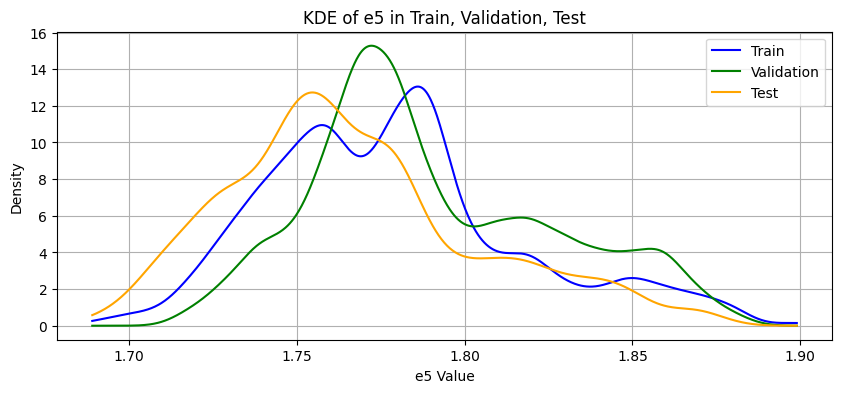

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-02-22 00:05:00 to 2025-02-28 00:00:00, to predict 1 day(s)
Test set range: 2025-02-22 00:05:00 to 2025-03-01 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0192 - val_loss: 0.0037
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Forecast MSE: 0.04015357434542636
                     Predicted E5
datetime                         
2025-02-28 00:00:00      1.769066
2025-02-28 00:05:00      1.770964
2025-02-28 00:10:00      1.769649
2025-02-28 00:15:00      1.770745
2025-02-28 00:20:00      1.770234


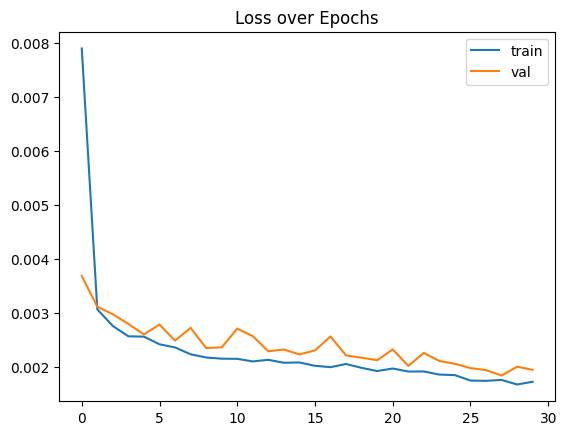

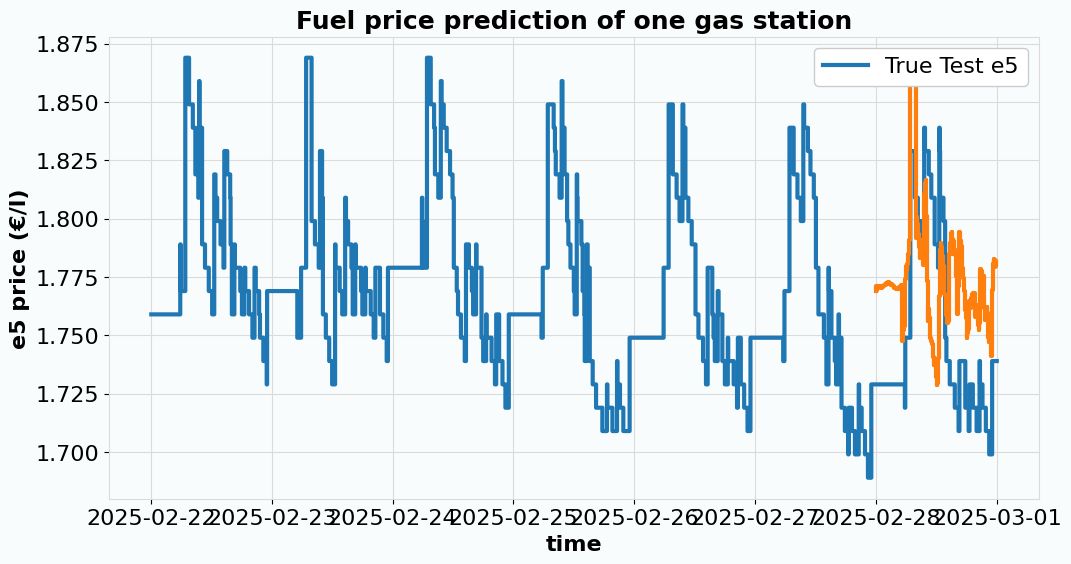

Successfully processed df28

Processing dataset: df29


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


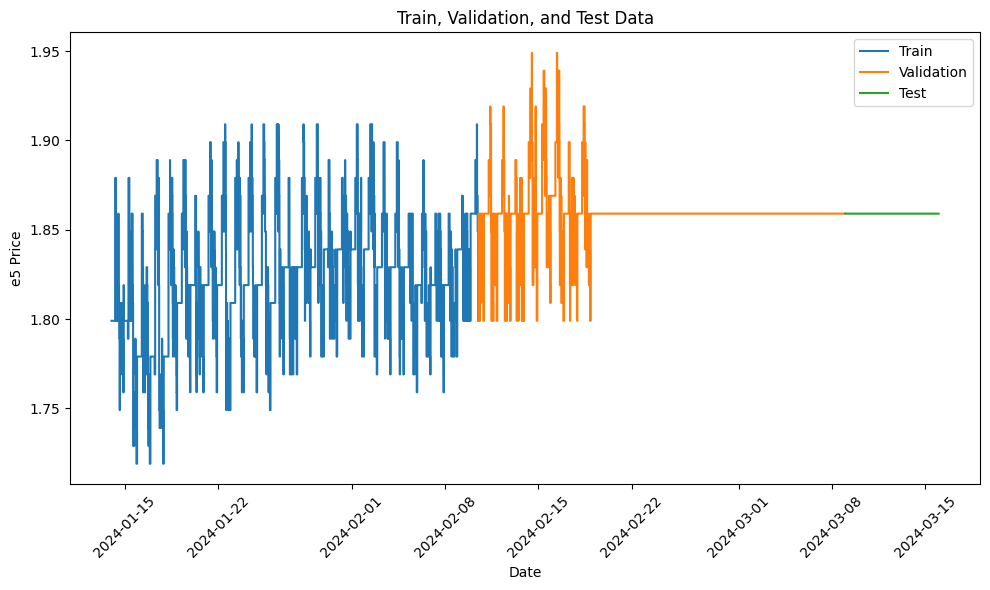

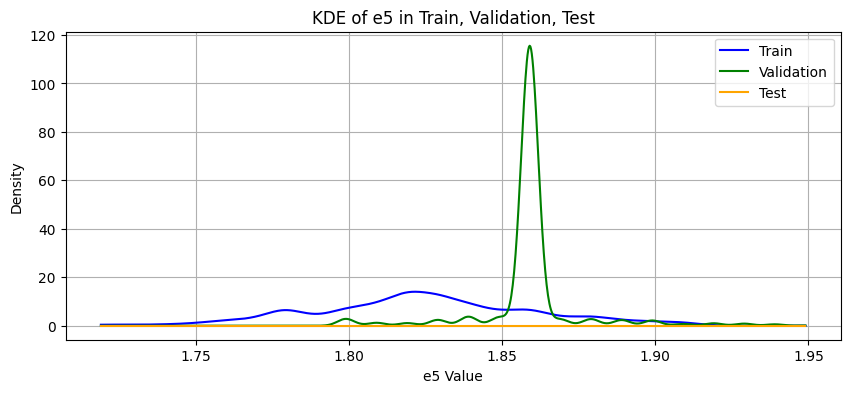

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-03-09 00:05:00 to 2024-03-15 00:00:00, to predict 1 day(s)
Test set range: 2024-03-09 00:05:00 to 2024-03-16 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0176 - val_loss: 0.0038
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/30
239/239 ━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Forecast MSE: 0.0003177177906039663
                     Predicted E5
datetime                         
2024-03-15 00:00:00      1.859318
2024-03-15 00:05:00      1.859318
2024-03-15 00:10:00      1.859318
2024-03-15 00:15:00      1.859318
2024-03-15 00:20:00      1.859318


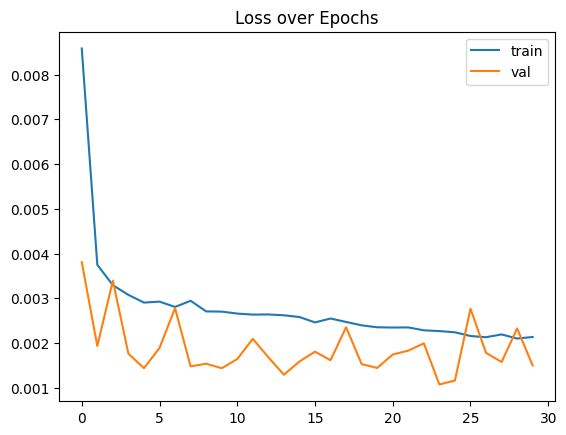

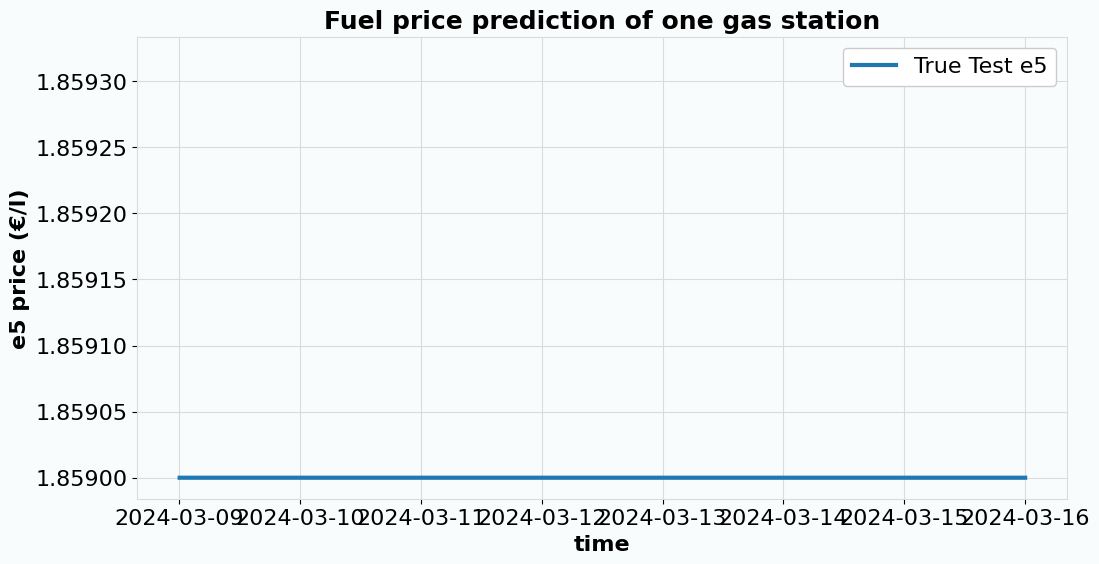

Successfully processed df29

Processing dataset: df30


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


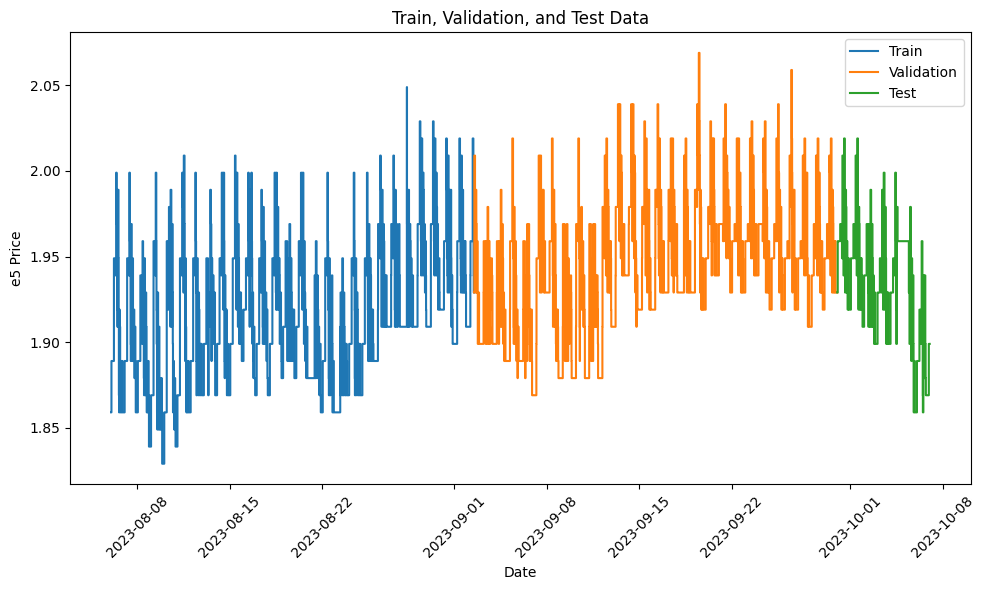

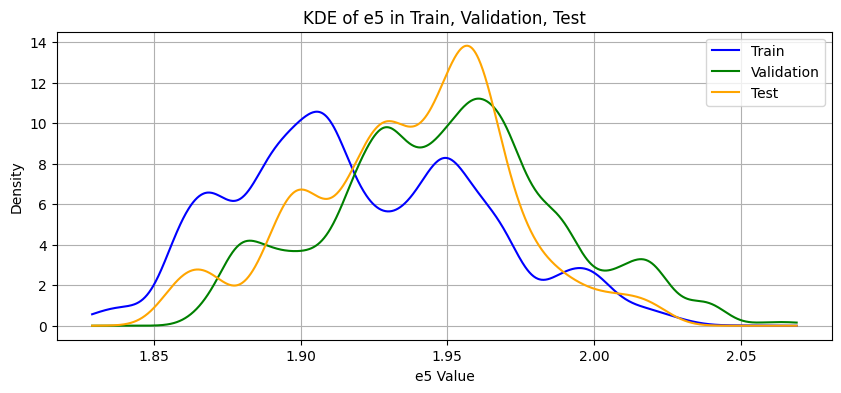

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-09-30 00:05:00 to 2023-10-06 00:00:00, to predict 1 day(s)
Test set range: 2023-09-30 00:05:00 to 2023-10-07 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.0462 - val_loss: 0.0026
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 12/30
239/239 ━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecast MSE: 0.06087339085837203
                     Predicted E5
datetime                         
2023-10-06 00:00:00      1.922852
2023-10-06 00:05:00      1.922839
2023-10-06 00:10:00      1.922675
2023-10-06 00:15:00      1.922657
2023-10-06 00:20:00      1.922509


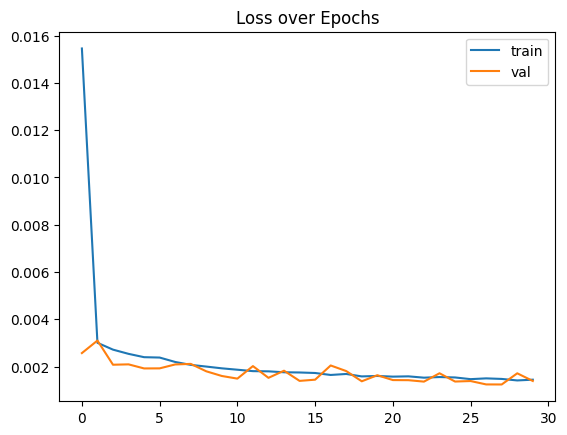

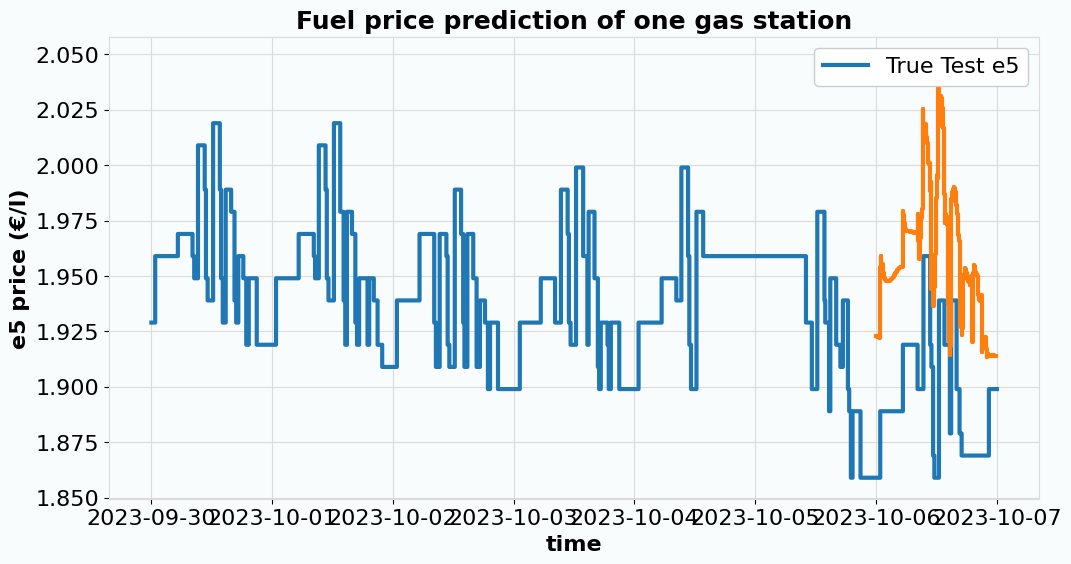

Successfully processed df30

=== Error Summary ===
Total errors: 2

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


In [20]:
# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_seasonality_{dataset_name}") as run:
            output_days = 1 # default
            fuel='e5' # default

            # PREPROCESSING
            X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
                    df_train=df_train, 
                    df_test=df_test, 
            )

            # MODELING
            params = {
                'epochs': 30,
                'batch_size': 32,
                'lstm_units': 50
            }

            model_type = 'cnn_lstm_1' # choose between: 'ccn_small', 'ccn_big' and 'cnn_lstm_1'
            
            trained_model, history = train_model_with_mlflow(
                X=X, 
                y=y, 
                X_val=X_val, 
                y_val=y_val,
                model_type=model_type,
                params=params
            )

            # FORECASTING
            forecasting(
                X_forecast=X_forecast, 
                scaled_train=scaled_train, 
                scaler=scaler, 
                model=trained_model
            )

        print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

=== Error Summary ===
Total errors: 2

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".

In [47]:
%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
